In [2]:
library("variancePartition")
library(dplyr)
library(tools)
library("DESeq2")
library(sva)
library(RColorBrewer)
library(pheatmap)
library('stringr')
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationDbi)

In [3]:
setwd("~/Downloads/GSE133506_RAW/")
files = list.files()

In [3]:
files
# drop c('AdiposeOWT_1', 'AdiposeOKO_4')
# files = c('AdiposeOKO_1.txt','AdiposeOKO_2.txt','AdiposeOKO_3.txt','AdiposeOWT_2.txt','AdiposeOWT_3.txt','AdiposeOWT_4.txt')

[1] "ATAC_RNA_DE.csv"         "GSM3910499_NM1_WT_1.txt"
[3] "GSM3910500_NM1_WT_2.txt" "GSM3910501_NM1_WT_3.txt"
[5] "GSM3910502_NM1_KO_1.txt" "GSM3910503_NM1_KO_2.txt"
[7] "GSM3910504_NM1_KO_3.txt" "sva_mef_cleaned.csv"

In [4]:
files = files[grepl("txt",files)]
counts_table = read.csv(files[1], header = F, sep = "\t")
colnames(counts_table) = c("V1", file_path_sans_ext(files[1]))
for (i in 2:length(files)) {
  counts_sample <- read.csv(files[i], header = F, sep = "\t")
  counts_table <- merge(counts_table, counts_sample, by = "V1")
  colnames(counts_table)[i + 1] <- file_path_sans_ext(files[i])
}
rownames(counts_table) = counts_table$V1
counts_table = subset( counts_table, select = -V1 )
print(dim(counts_table))
counts_matrix = as.matrix(counts_table)
counts_matrix = counts_matrix[rowSums(counts_matrix) > 0, ]
print(dim(counts_matrix))
head(counts_table)


[1] 46603     6
[1] 25902     6


,GSM3910499_NM1_WT_1,GSM3910500_NM1_WT_2,GSM3910501_NM1_WT_3,GSM3910502_NM1_KO_1,GSM3910503_NM1_KO_2,GSM3910504_NM1_KO_3
,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,940,1045,874,2911,2797,2005
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,247,307,264,484,246,367
ENSMUSG00000000031,31090,37449,46633,49412,36831,36696
ENSMUSG00000000037,6,2,7,19,16,14
ENSMUSG00000000049,3,6,1,3,4,4


In [5]:
counts_metadata = data.frame(colnames(counts_matrix),
                             NA, NA,
                             stringsAsFactors = FALSE)
colnames(counts_metadata) = c("sample", "genotype", "replicate")
# counts_metadata$age = 'O'
# counts_metadata$age[grepl("Y",counts_metadata$sample)] = 'Y'
# counts_metadata$genotype = str_replace(counts_metadata$sample, 'GSM3910', '')
# counts_metadata$genotype = str_replace(counts_metadata$genotype, 'AdiposeY', '')
counts_metadata$genotype = str_split(counts_metadata$sample, '_', simplify = T)[,3]
counts_metadata$replicate = as.numeric(str_split(counts_metadata$sample, '_', simplify = T)[,4])
counts_metadata

sample,genotype,replicate
<chr>,<chr>,<dbl>
GSM3910499_NM1_WT_1,WT,1
GSM3910500_NM1_WT_2,WT,2
GSM3910501_NM1_WT_3,WT,3
GSM3910502_NM1_KO_1,KO,1
GSM3910503_NM1_KO_2,KO,2
GSM3910504_NM1_KO_3,KO,3


In [6]:
gene_id = read.csv('/Volumes/GS4T/WORK/SAMIRA/ensmus_id.tsv', sep = '\t', row.names = 1, header=F)
colnames(gene_id) = 'symbol'
rownames(counts_matrix) = gene_id[rownames(counts_matrix),]

In [ ]:
# rm AdiposeOWT_1

In [7]:
dds = DESeqDataSetFromMatrix(countData = counts_matrix,
                              colData = counts_metadata,
                              design = ~ genotype + replicate ) %>% estimateSizeFactors() %>% estimateDispersions()
# counts_metadata

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“154 duplicate rownames were renamed by adding numbers”
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [8]:
dds <- DESeq(dds)
idx = rowMeans(counts(dds)) > 16
dat = counts(dds)[idx,]
mod = model.matrix(~  genotype + replicate, colData(dds))
mod0 = model.matrix(~ 1, colData(dds))
svseq = svaseq(dat, mod, mod0)


using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

In [9]:
ddssva = dds[idx,]
ddssva$SV1 = svseq$sv[,1]
# ddssva$SV2 = svseq$sv[,2]
# ddssva$SV3 = svseq$sv[,3]

design(ddssva) = ~ SV1 + genotype + replicate
ddssva = DESeq(ddssva)


using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [10]:
# res = results(dds, name="phenotype_WT_vs_KO")
res = lfcShrink(ddssva, coef="genotype_WT_vs_KO", type="apeglm")


using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [11]:
`%nin%` = Negate(`%in%`)
subr = res
# subr = subset(res, rownames(res) %nin% c('Gm8797') & padj<=.05)
# subr = subset(res, padj<=.05)

Warning message:
“ggrepel: 907 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


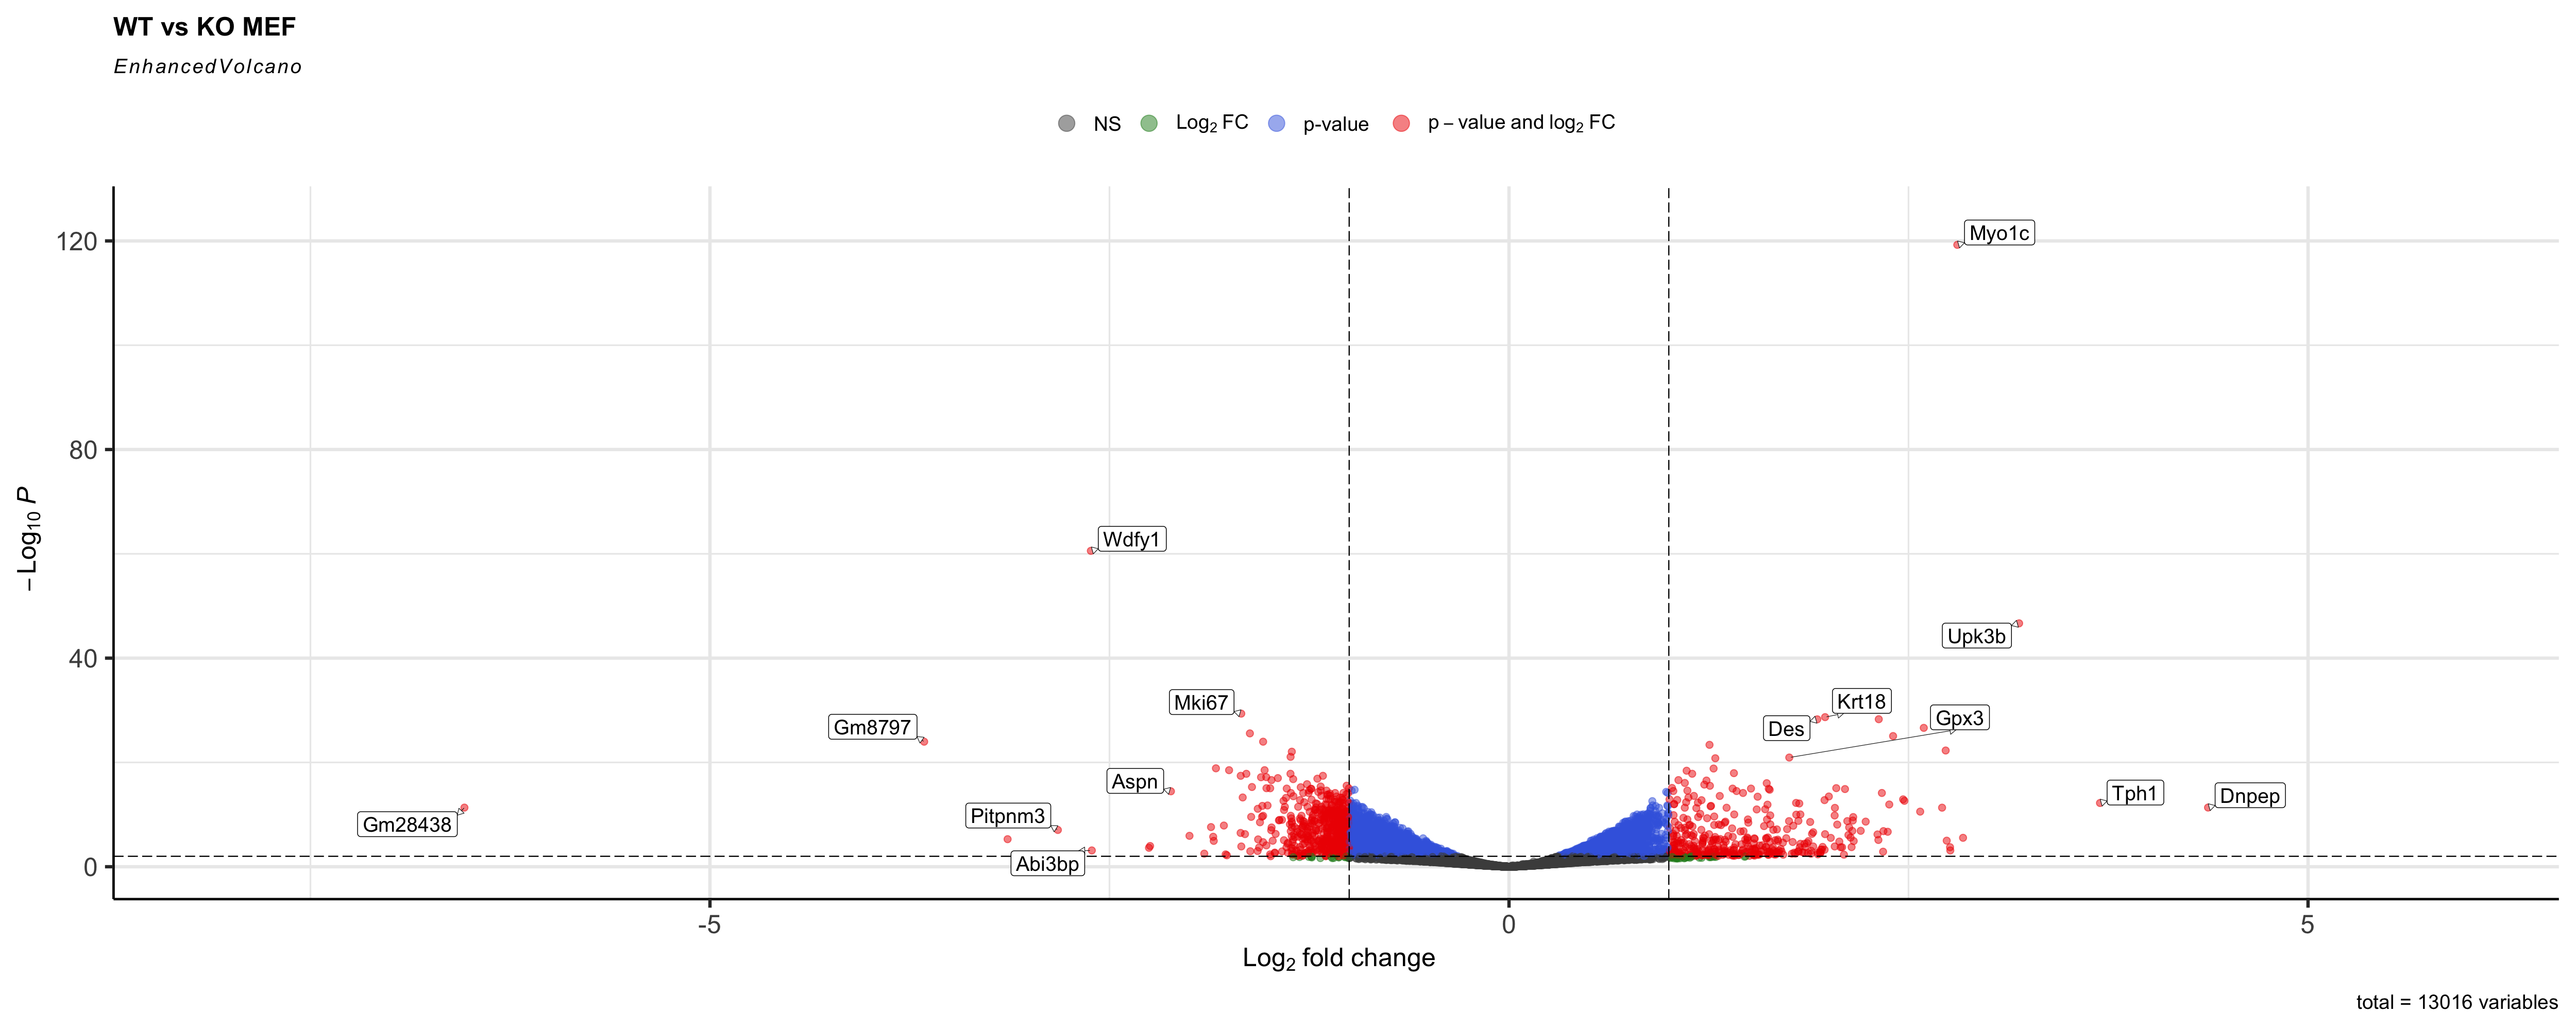

In [29]:
library(EnhancedVolcano)

# meanSdPlot(assay(dds))
# res
# if (!requireNamespace('BiocManager', quietly = TRUE))
#     install.packages('BiocManager')
# library('EnhancedVolcano')
options(repr.plot.width=25, repr.plot.height=10)

EnhancedVolcano(subr,
lab = rownames(subr),
x = 'log2FoldChange', boxedLabels = T,
                drawConnectors = TRUE,
    widthConnectors = 0.2,title= 'WT vs KO MEF',
y = 'padj',FCcutoff = 1, pCutoff = 10e-3)


In [27]:
# meanSdPlot(assay(vsd))


In [13]:
vsd = vst(ddssva, blind=FALSE)
sampleDists = dist(t(assay(vsd)))
sampleDistMatrix = as.matrix(sampleDists)
rownames(sampleDistMatrix) = vsd$sample
colnames(sampleDistMatrix) = vsd$sample

In [14]:
rownames(counts_metadata) = counts_metadata$sample
counts_metadata$replicate = as.character(counts_metadata$replicate)

In [15]:
tmp_meta = subset(vsd@colData, select = -sample)
tmp_meta = subset(tmp_meta, select = -replicate)

In [16]:
tmp_meta = data.frame(tmp_meta)
tmp_meta = subset(tmp_meta, select = -sizeFactor)

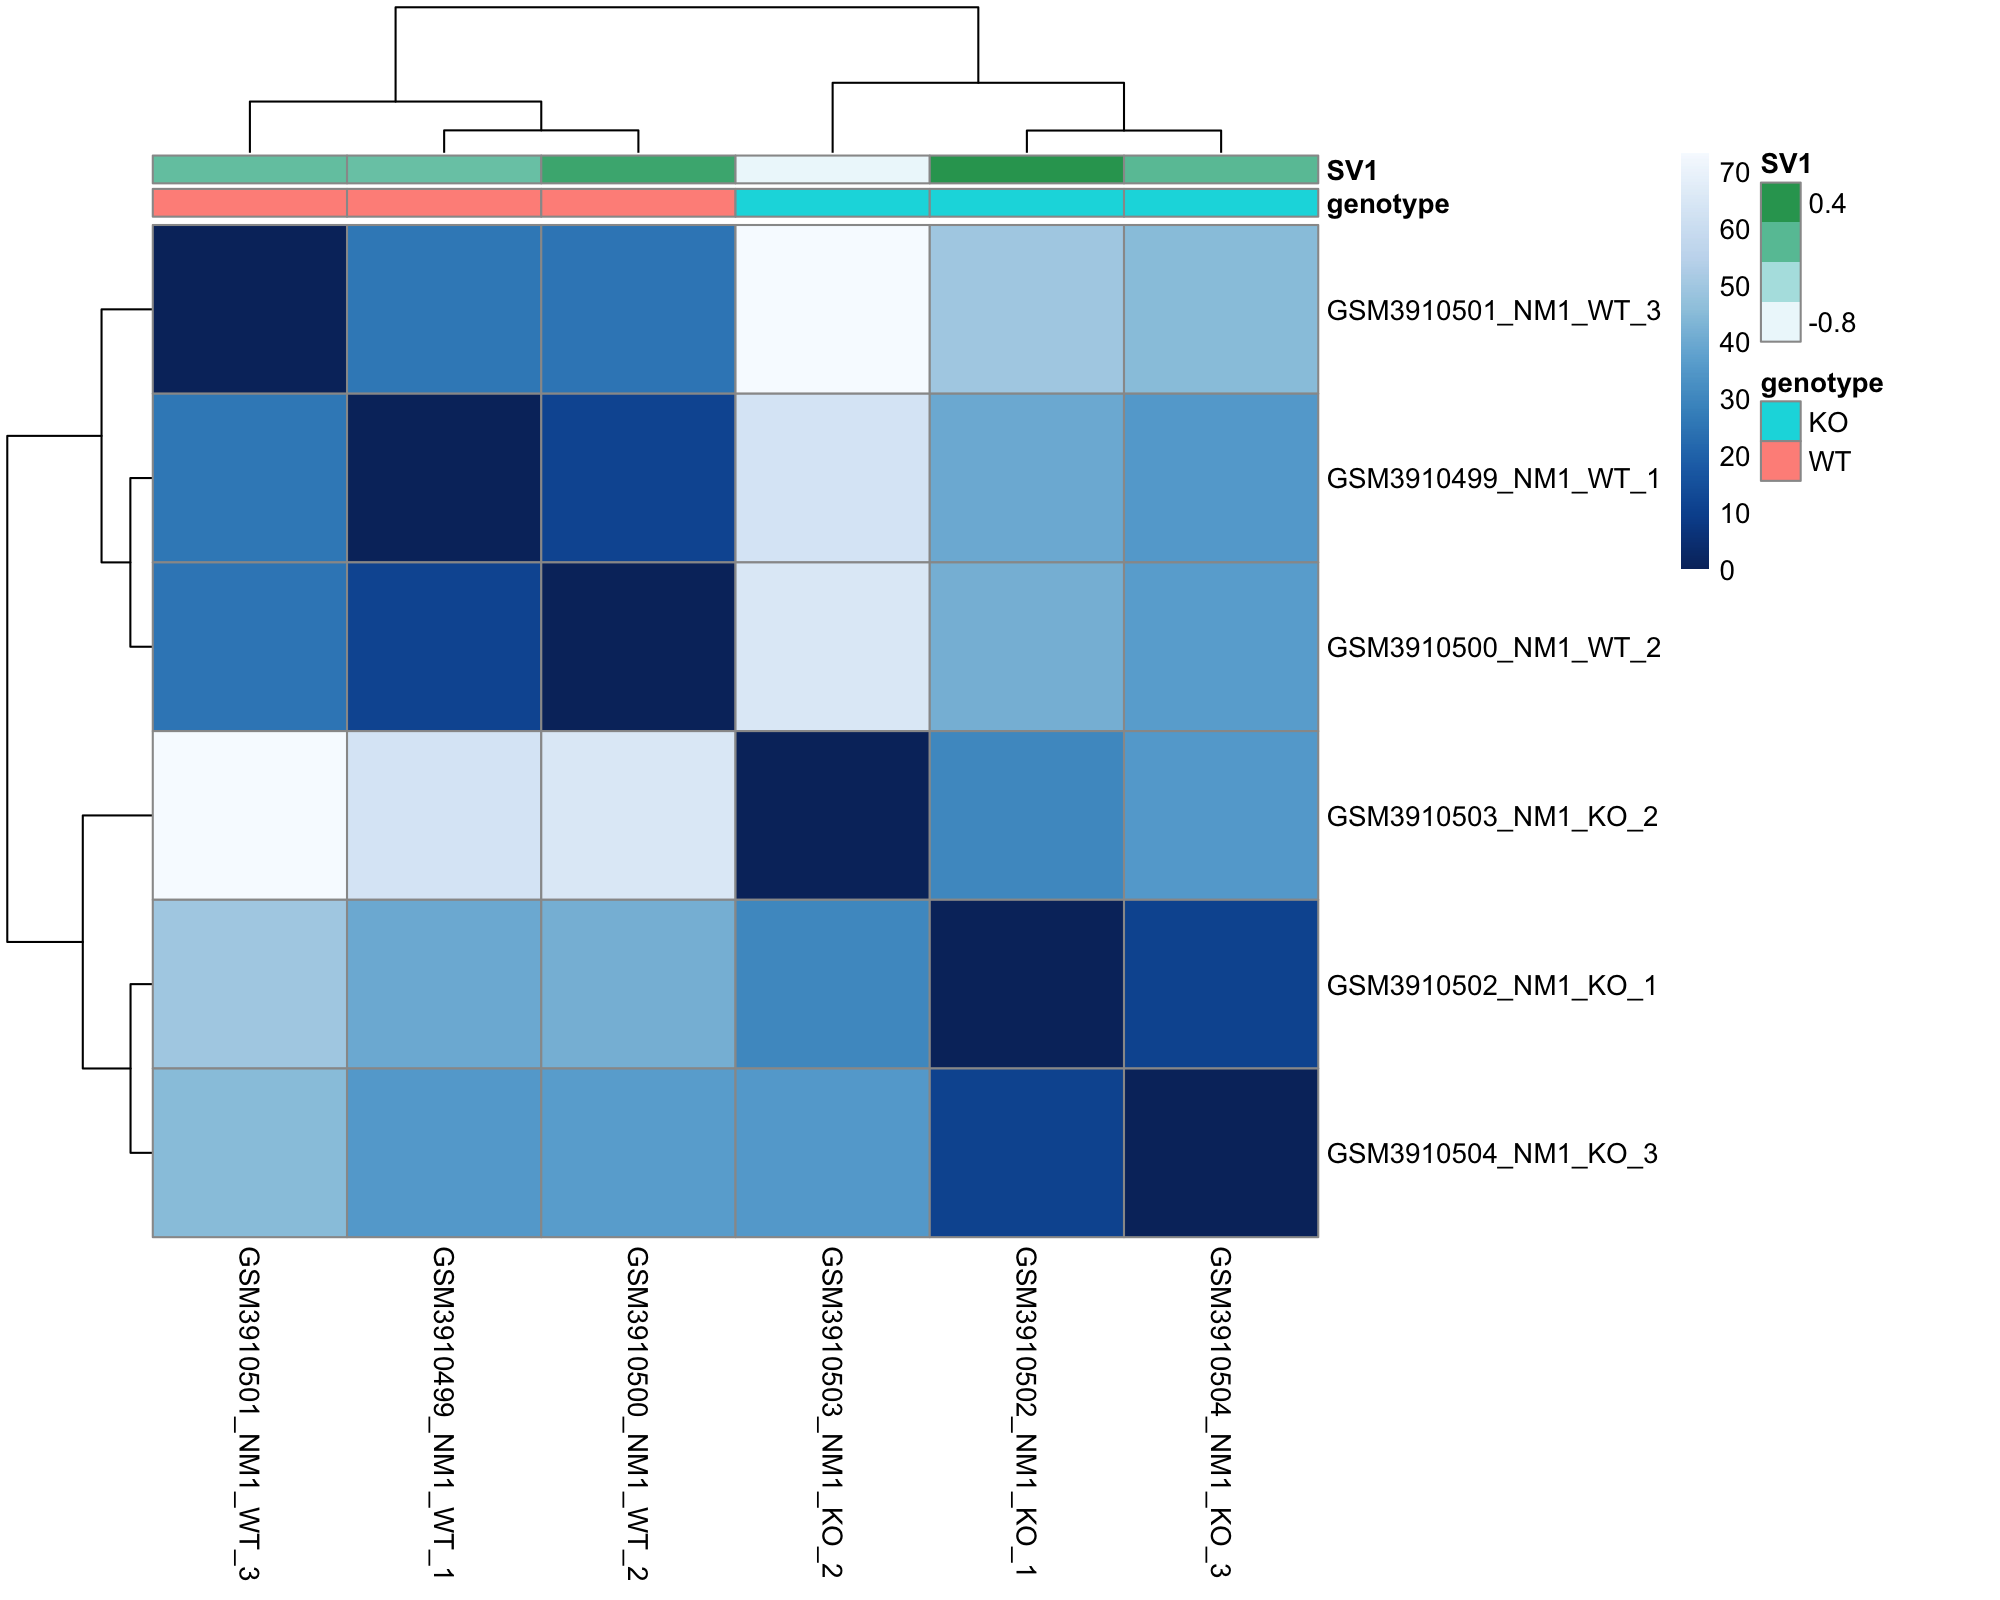

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors, show_rownames=T, annotation_col=tmp_meta)

In [ ]:
# drop c('AdiposeOWT_1', 'AdiposeOKO_4')

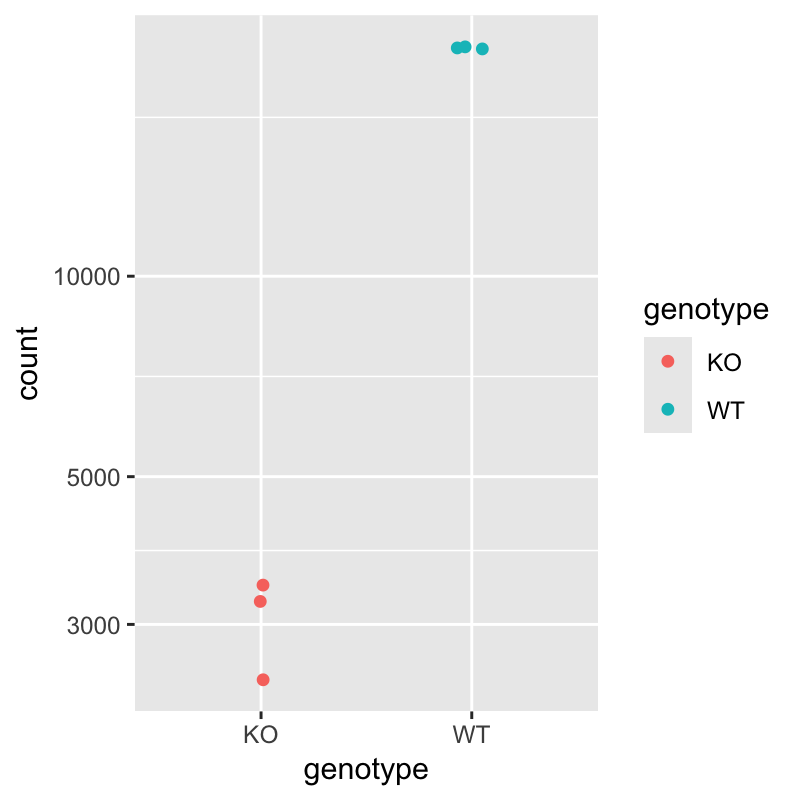

In [27]:
library(ggplot2)
d = plotCounts(dds, gene=c('Myo1c'), intgroup=c("genotype","replicate"), returnData=TRUE)
ggplot(d, aes(x=genotype, y=count, color=genotype)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) + 
  scale_y_log10()

In [31]:
# d = plotCounts(dds, gene=c( 'Xist'), intgroup=c("phenotype","age"), returnData=TRUE)
# ggplot(d, aes(x=ge, y=count, color=age)) + 
#   geom_point(position=position_jitter(w=0.1,h=0)) + 
#   scale_y_log10()

In [80]:
# dds@colData$Xist = 'low'
# dds@colData[rownames(subset(d, count>1000)),'Xist'] = 'high'

In [82]:
# vsd@colData$Xist = 'low'
# vsd@colData[rownames(subset(d, count>1000)),'Xist'] = 'high'

using ntop=500 top features by variance



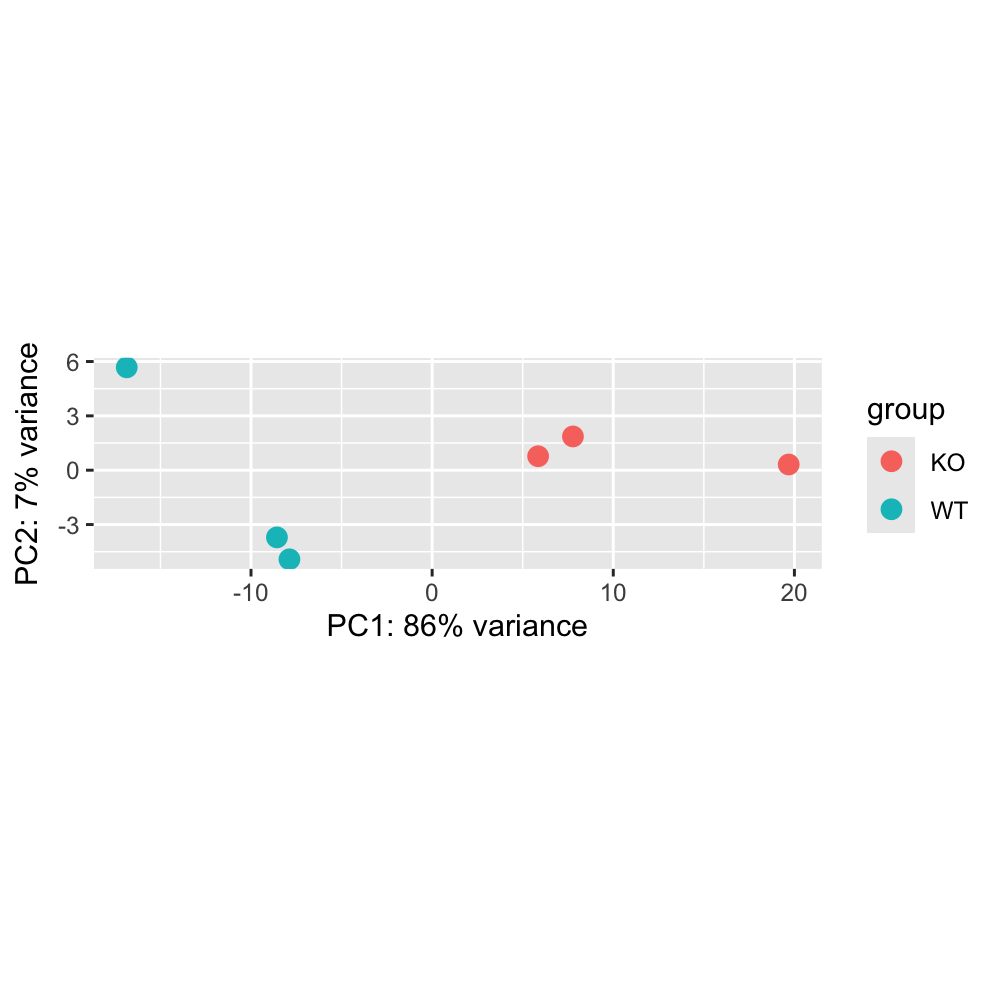

In [28]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plotPCA(vsd, intgroup=c('genotype'))
# plotPCA(vsd, intgroup=c('phenotype','age'))

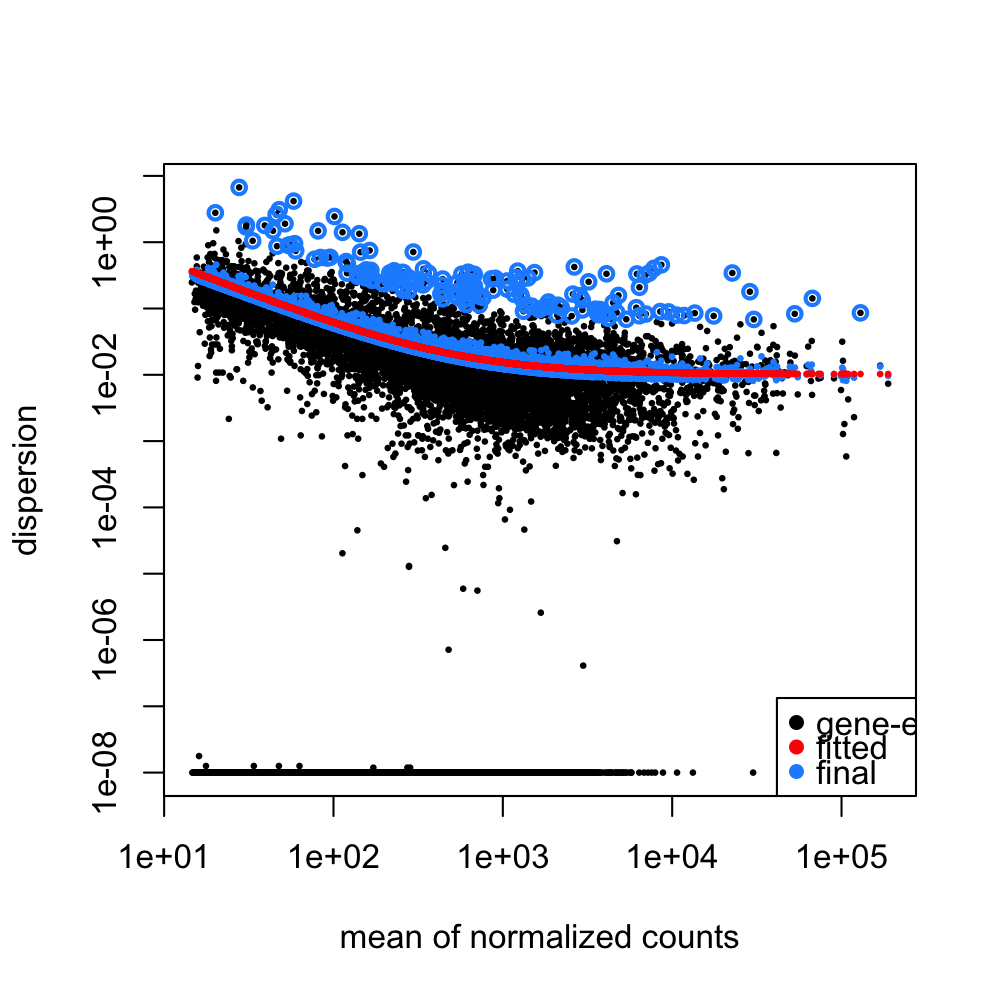

In [20]:
plotDispEsts(ddssva)

In [21]:
vsd = vst(ddssva, blind=FALSE)

my_form = ~ genotype  + replicate + SV1 
varPart = fitExtractVarPartModel(assay(vsd), my_form, colData(ddssva))



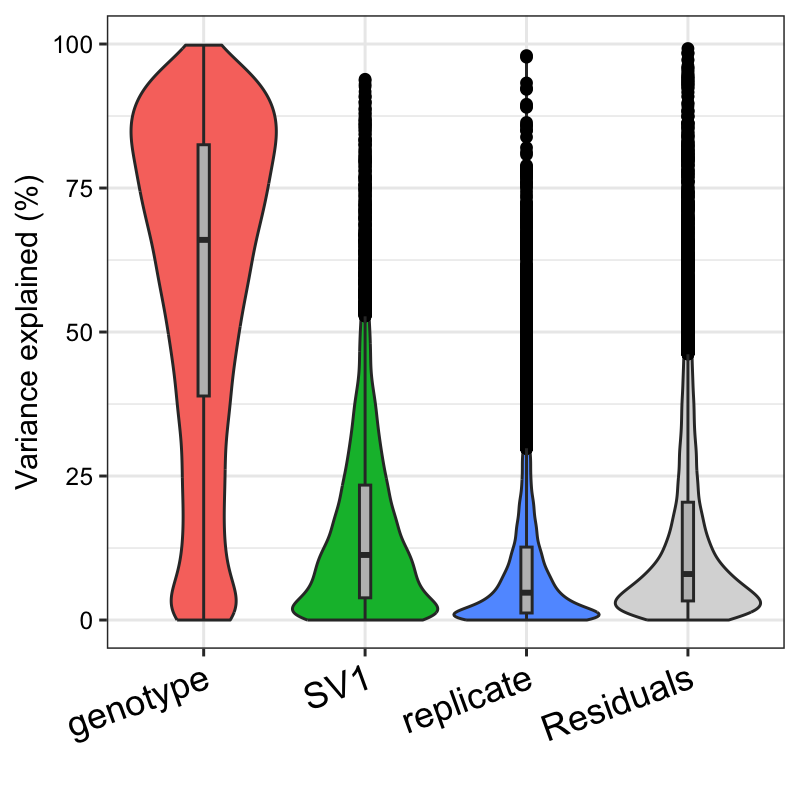

In [22]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)
plotVarPart(sortCols(varPart))

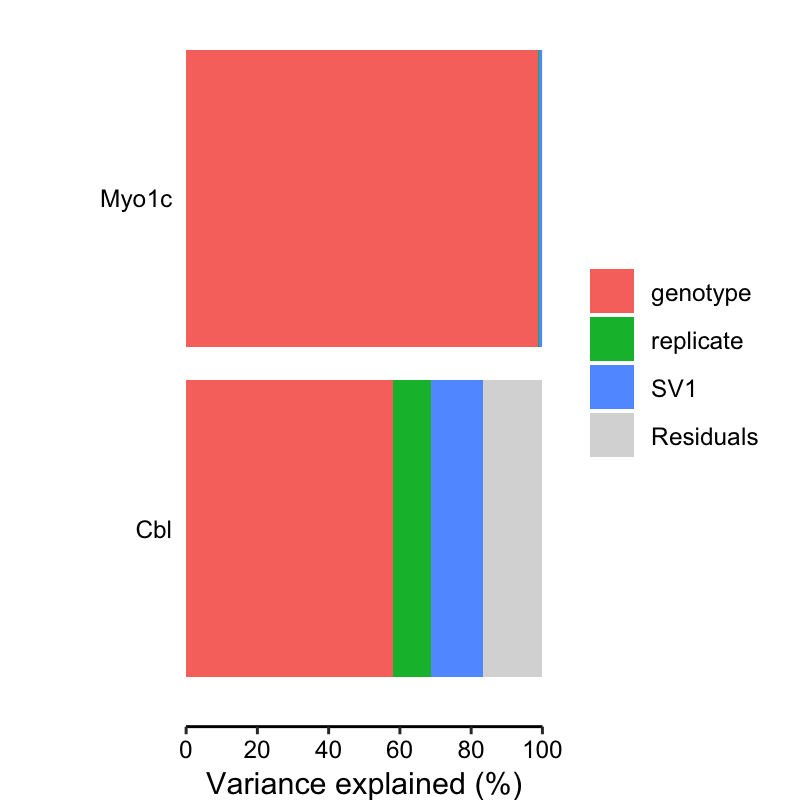

In [23]:
plotPercentBars(varPart[c('Myo1c','Cbl'),])

In [24]:
varPart[which(varPart$genotype>=.78),]

,genotype,replicate,SV1,Residuals
,<dbl>,<dbl>,<dbl>,<dbl>
Gnai3,0.8700829,1.151041e-02,1.026730e-01,0.015733665
Cav2,0.8742396,2.451603e-02,9.425987e-02,0.006984512
Klf6,0.8449275,5.156903e-05,3.589316e-02,0.119127796
Fer,0.8243388,3.593180e-02,1.249978e-01,0.014731562
Tfe3,0.7815015,1.047294e-02,1.891267e-01,0.018898868
Brat1,0.8472331,4.146375e-02,2.398412e-02,0.087319012
Sdhd,0.7903624,4.493127e-02,5.032001e-02,0.114386348
Gpr107,0.9687904,9.917709e-03,2.012857e-02,0.001163330
Itgb2,0.9146839,1.446605e-02,7.587799e-03,0.063262250


In [25]:
summary(varPart$genotype)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.3889  0.6600  0.5878  0.8251  0.9980 

In [62]:
# dat = counts(dds, normalized=TRUE)
# mod = model.matrix(~ replicate + phenotype + age, colData(dds))
# mod0 <- model.matrix(~ 1 , colData(dds))
# n.sv <- num.sv(dat, mod, method = "be")
# print(n.sv)
# svseq <- svaseq(dat, mod, mod0, n.sv=n.sv)
# head(svseq$sv)

In [ ]:
# Also chart the results section from the figure 
# potentially correlate with HiC
# 

In [24]:
# write.csv(res, 'sva_mef_cleaned.csv')
# res

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0140694,GO:0140694,non-membrane-bounded organelle assembly,180/4630,402/28891,1.112680e-42,7.148967e-39,3.502013e-39,Kat2b/Chmp1a/Ddx3x/Fmr1/Poldip2/Tubb5/Mybpc3/Hck/Tpr/Casq1/Tcap/Vps4b/Kif11/Rps5/Pten/Nkx2-5/Zfp207/Rrp7a/Ncor1/Trim37/Fbxo5/Hdac2/Cnot2/Csrp2/Mdm1/Cnot6/Drg1/Dbnl/Pum2/4933427D14Rik/Myh10/Krt19/Asb2/Eif5/Mterf3/Kif2a/Cenpk/Ldb3/Mapk8/Lcp1/Pibf1/Fitm1/Brix1/Sqle/Bop1/Prkdc/Rttn/Ndc80/Washc1/Cep192/Rps14/Ddb1/Sac3d1/Smc3/Cenpx/Chmp6/Plk4/Stag2/Cflar/Eif5b/Csrp1/Nek2/Gsn/Caprin1/Haus2/Tpx2/Eif6/Fxr1/Eif2a/Gpsm2/Sass6/Myoz2/Gtf2b/Tmod1/Chmp5/Stil/Mfn2/Wrap73/Mrpl20/Mapre3/Pdgfra/Cenpc1/Kntc1/Fscn1/Rpl6/Pan3/Ppp1r35/Csrp3/Rps3/Abraxas2/Bccip/Pqbp1/Cetn2/Myom2/Cnot7/Acta1/Ddx6/Kif23/Rpsa/Mzt1/Clasp2/Arhgef5/Stard9/Tubgcp5/Map9/Ccp110/Aspm/Ino80/Chmp7/Senp6/Six4/Cnot6l/Abraxas1/Mpv17l2/Abt1/Cep135/Cnot1/Stag1/Dlgap5/Haus6/Fau/Nop2/Rpf2/Prc1/Cdk5rap2/Synpo2l/Hnrnpu/Neurl2/Prrc2c/Rc3h1/Mis12/Rps19/Smc1a/Dicer1/Nop53/Pgm5/Lmod3/Cenph/Cenpe/Cep295/Mrps7/Cltc/Ythdf3/Lmod1/Nrap/Krt8/Actn2/Ep300/Jmjd6/Npm1/Mdn1/Tmod3/Cds2/Rpl11/Tnnt3/Mospd2/Cav3/Actg1/Rps15/Alms1/Cenpj/Tnnt1/mt-Rnr2/Akap13/Lsm14a/Rplp0/Myl9/Aup1/Cep152/Actc1/Csde1/Rnf213/Tia1/Bscl2/Klhl41/Capn3/Xirp1/Haus3/Rps6-ps4/Rps27,180
GO:0008380,GO:0008380,RNA splicing,184/4630,449/28891,3.666423e-37,1.177838e-33,5.769792e-34,Arvcf/Kat2b/Fmr1/Crnkl1/Srpk3/Celf2/Puf60/Cdk12/Taf6l/Akt2/Hnrnpa2b1/Celf1/Hnrnph1/Snrpb2/Myod1/Rbm25/Sugp1/Nol3/Hnrnpl/Hspa8/Wt1/Srsf1/Fxr2/Hnrnph3/Clk4/Taf15/Ddx5/Tsen54/Luc7l3/Pnn/Srsf5/Prpf4b/Snrnp48/Habp4/Ddx46/Hnrnpk/Ppwd1/Srek1ip1/Atxn7/Sap18/Zc3h13/Wbp4/Mbnl2/Eny2/Slc38a2/Zcrb1/Ppil2/Tra2b/Son/Paxbp1/Prmt5/Ivns1abp/Pcbp4/Hnrnpll/Snrpc/Thoc1/Iws1/Tcerg1/Prpf19/Alyref/Cwf19l2/Sf3b1/Clk1/Ncl/Prdx6/Cwc22/Snrpb/Rbm38/Raly/Rbm39/Aar2/Ctnnbl1/Fxr1/Supt20/Mbnl1/Ccnl1/Prpf38b/Larp7/Rnpc3/Mettl14/Ptbp2/Zranb2/Ptbp3/Psip1/Ppie/Srsf10/Sfpq/Ccnl2/Dhx15/Rest/Zfp326/Tfip11/Zcchc8/Rbm19/Rbm28/Tra2a/Luc7l2/Zfp638/Magohb/Fus/Rbmx2/Pqbp1/Aff2/Zrsr2/Rbm41/Usb1/Zpr1/Syncrip/Rbm5/Rbm6/Usp4/Srek1/Scaf11/Thoc5/Rsrc1/Gcfc2/Tsen34/Prpf39/Ythdc1/Rbmxl1/Rbm17/Rsrp1/Thoc2/Nsrp1/Cdc40/Bud31/Srrm2/Prpf18/Hnrnpu/Zc3h10/Virma/Snrpd2/Cdk13/Pik3r1/Tardbp/Cir1/Hnrnpf/Rbm7/Dhx9/Setx/Taf10/Thrap3/Lsm8/Gemin7/Hnrnph2/Hnrnpa1/Rbm12b1/Rbm15/Tada3/Lsm10/Lgals3/Rbm12b2/Ppp4r2/Prx/Thoc7/Fra10ac1/Mettl4/Gemin6/Jmjd6/Npm1/Pus7/Hnrnpa3/Hnrnpm/Akap17b/Prmt7/Sap18b/Prpf40a/Srpk2/Nup98/Fam172a/Htatsf1/Mfap1a/Clk2/Ahnak/Srsf3/Tia1/Sf3b5/U2af1l4/Esrp2/Rbm12/Rps13/Lsm5/Malat1/Snrpn,184
GO:0022613,GO:0022613,ribonucleoprotein complex biogenesis,179/4630,440/28891,1.093445e-35,2.341795e-32,1.147158e-32,Mcts1/C1d/Kat2b/Ddx3x/Nhp2/Mrpl10/Nom1/Crnkl1/Srpk3/Celf2/Ipo4/Puf60/Pih1d1/Rps11/Nob1/Utp20/Ddx56/Bud23/Celf1/Rsl1d1/Rps9/Rps5/Pten/Nol3/Tsr3/Eif3d/Rrp7a/Srsf1/Nop9/Ddx21/Xpo1/Pes1/Ddx52/Luc7l3/Gtpbp4/Hsp90aa1/Eif5/Nol8/Mterf3/Brix1/Bop1/Prkdc/Tarbp2/Denr/Prmt5/Rrp36/Bysl/Snrpc/Wdr46/Rbfa/Rps14/Prpf19/Rpp30/Eif3a/Tma16/Usp16/Sf3b1/Wdr75/Nop58/Eif5b/Ncl/Cdc73/Eif2d/Tfb2m/Nvl/Snrpb/Eif6/Aar2/Exosc9/Exosc8/Mbnl1/Nmd3/Eif2a/Ptbp2/Rpf1/1700009N14Rik/Psip1/Srsf10/Ago3/Gnl2/Mrpl20/Zcchc4/Sdad1/Ddx54/Rpl6/Pop7/Malsu1/Luc7l2/Bms1/Pop4/Mphosph10/Eri2/Cul4b/Dkc1/Eri1/Mphosph6/Urb2/Atr/Rpsa/Rbm5/Usp4/Dis3/Scaf11/Wdr3/Eri3/Rbm34/Atm/Gcfc2/Eif2s3x/Mpv17l2/Utp6/Prpf39/Wdr18/Ythdc1/Serbp1/Abt1/Nop14/Rsrp1/Rps16/Rpl10a/Mrm3/Fau/Nop2/Tsr1/Rpf2/Prpf18/Dnttip2/Gtpbp10/Ckap5/Tbl3/Snrpd2/Rps19/Wdr43/Dicer1/Rrp9/Nop53/Wdr55/Dhx9/Wdr74/Setx/Gemin7/Esf1/Mrps7/Isg20l2/Rps27rt/Rps19bp1/Zfp622/Ddx10/Grwd1/Utp18/Cpsf6/Gemin6/Npm3/Npm1/Ddx49/Mdn1/Abce1/Rpl11/Prmt7/Pop5/Exosc5/Srpk2/Rpl7a/Nol7/Rpl27/Krr1/Rps15/mt-Rnr2/Rplp0/Lyar/Eif2s3y/Ptges3/Rpl13a/Eif2s2/Utp14b/Pin4/Rps6-ps4/Rps27/Rps13,179
GO:0006397,GO:0006397,mRNA processing,188/4630,496/28891,1.392010e-32,2.235916e-29,1.095292e-29,Arvcf/Tbrg4/Fmr1/Crnkl1/Srpk3/Celf2/Puf60/Cdk12/Slbp/Hnrnpa2b1/Celf1/Aplp1/Hnrnph1/Snrpb2/Myod1/Rnmt/Rbm25/Sugp1

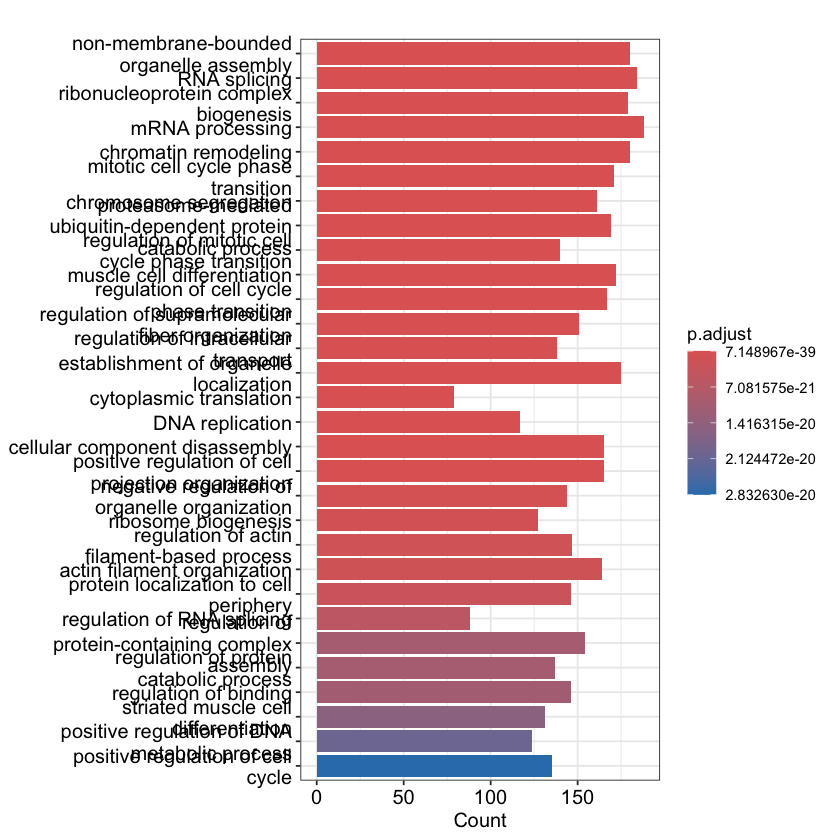

In [28]:
res = read.csv('/Users/gas361/Downloads/GSE133506_RAW/sva_mef_cleaned.csv')
genes_to_test = subset(res,(log2FoldChange >= 0.5 | log2FoldChange <= -0.5 )& padj <= 0.05 & baseMean >= 16)[,1]
GO_results = enrichGO(gene = genes_to_test, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 30))


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050900,GO:0050900,leukocyte migration,41/526,398/28891,3.581502e-19,1.668622e-15,1.056732e-15,Itgb2/Ccl3/Ccl8/Mmp9/Lyst/Lgmn/Cxcl14/Nckap1l/Retnlg/Cd200r1/Vegfa/Trem2/Rock1/Myo1f/Ptprj/Adam8/Podxl/Abl2/Vcam1/Pf4/Flt1/Ptpro/Cd9/Lyve1/F7/Vegfc/Slit2/Mmp2/Smpd3/Thy1/Cadm1/Cd300a/Serpine1/C3ar1/Rin3/S1pr1/Wnk1/Cd24a/Lgals3/Lep/Fcgr3,41
GO:0007162,GO:0007162,negative regulation of cell adhesion,36/526,315/28891,1.932848e-18,4.502571e-15,2.851460e-15,Col1a1/Cd44/Fbln1/Notch4/Sema4d/Nckap1l/Vegfa/Myo1f/Lpxn/Adam8/Podxl/Abl2/Myoc/Il1rn/Ccm2l/Tnc/Gpnmb/Cd9/Mmp2/Jak3/Cd300a/H2-Aa/Serpine1/Gimap3/Pla2g2d/Cdkn2a/Wnk1/Cd24a/Mmp12/Fzd4/Lgals3/Vtcn1/Prkg1/Lilrb4a/Plxnc1/Ass1,36
GO:0030198,GO:0030198,extracellular matrix organization,34/526,322/28891,1.998624e-16,2.248661e-13,1.424068e-13,Col1a1/Fbln1/Wt1/Vtn/Mmp9/Myh11/Lama2/Lcp1/Col14a1/Mmp19/Col5a2/Col3a1/Dpt/Abl2/Eng/Pdgfra/Col1a2/Mmp2/Smpd3/Agt/Tie1/Atp7a/Loxl2/Adamtsl2/Ctss/Mfap4/Mmp3/Adamts12/Mmp12/Lgals3/Spock2/Hmcn1/Tcf15/Col8a1,34
GO:0045229,GO:0045229,external encapsulating structure organization,34/526,323/28891,2.196570e-16,2.248661e-13,1.424068e-13,Col1a1/Fbln1/Wt1/Vtn/Mmp9/Myh11/Lama2/Lcp1/Col14a1/Mmp19/Col5a2/Col3a1/Dpt/Abl2/Eng/Pdgfra/Col1a2/Mmp2/Smpd3/Agt/Tie1/Atp7a/Loxl2/Adamtsl2/Ctss/Mfap4/Mmp3/Adamts12/Mmp12/Lgals3/Spock2/Hmcn1/Tcf15/Col8a1,34
GO:0043062,GO:0043062,extracellular structure organization,34/526,324/28891,2.413244e-16,2.248661e-13,1.424068e-13,Col1a1/Fbln1/Wt1/Vtn/Mmp9/Myh11/Lama2/Lcp1/Col14a1/Mmp19/Col5a2/Col3a1/Dpt/Abl2/Eng/Pdgfra/Col1a2/Mmp2/Smpd3/Agt/Tie1/Atp7a/Loxl2/Adamtsl2/Ctss/Mfap4/Mmp3/Adamts12/Mmp12/Lgals3/Spock2/Hmcn1/Tcf15/Col8a1,34
GO:0045765,GO:0045765,regulation of angiogenesis,33/526,307/28891,3.293949e-16,2.557751e-13,1.619814e-13,Itgb2/Serpinf1/Aqp1/Sash1/Cybb/Notch4/Mmp9/Ptgis/Pik3cg/Rapgef3/Cela1/Thbs2/Vegfa/Rock1/Eng/Nos3/Flt1/Itgax/Vegfc/Cdh5/Bmper/Agt/Tie1/Serpine1/C3ar1/Isl1/Gpr4/Wnk1/Lgals3/Adam12/Lep/Hipk2/Kdr,33


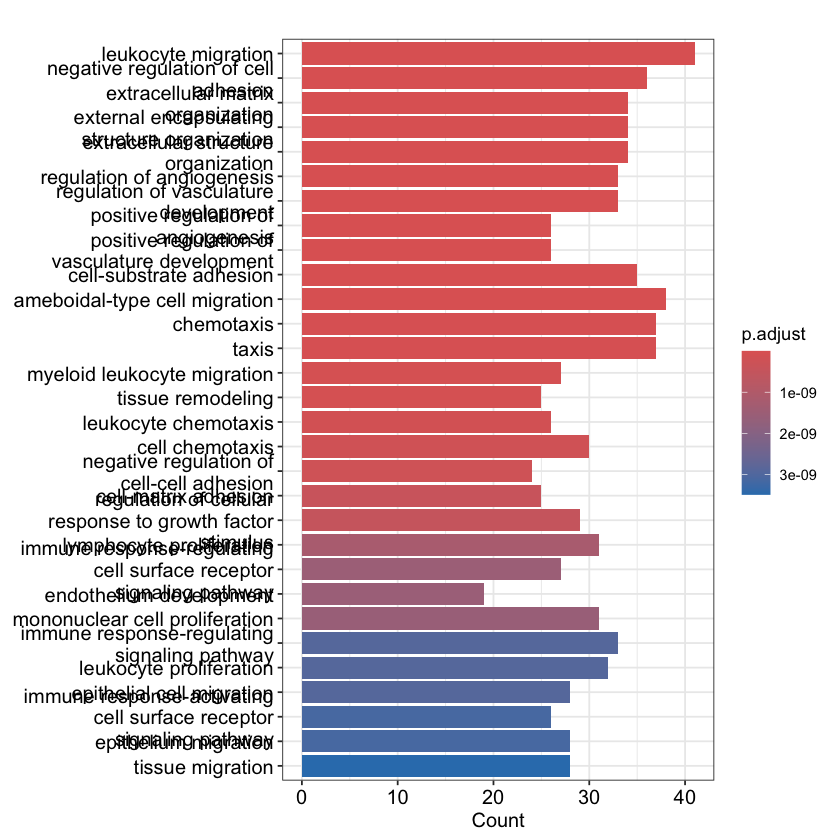

In [29]:
# /Users/gas361/Downloads/GSE133506_RAW/sva_mef_cleaned.csv
res = read.csv('/Users/gas361/Downloads/adipose/sva_adipose_cleaned.csv')
genes_to_test = subset(res,(log2FoldChange >= 0.5 | log2FoldChange <= -0.5 )& padj <= 0.05 & baseMean >= 16)[,1]
GO_results = enrichGO(gene = genes_to_test, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 30))

# subset(res,(log2FoldChange > 0.5 | log2FoldChange <= -0.5 )& padj < 0.05 & baseMean > 50)[,1]

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050900,GO:0050900,leukocyte migration,23/243,398/28891,5.171784e-13,1.878909e-09,1.356641e-09,Ptprj/Vcam1/Lgmn/Nckap1l/Rock1/Abl2/Wnk1/Lyst/Rin3/Myo1f/Smpd3/Trem2/Lgals3/Cxcl14/Serpine1/Slit2/C3ar1/Fcgr3/Adam8/Itgb2/Cd9/Cd300a/Vegfa,23
GO:0002685,GO:0002685,regulation of leukocyte migration,18/243,249/28891,4.751342e-12,3.979254e-09,2.873166e-09,Ptprj/Lgmn/Nckap1l/Abl2/Wnk1/Rin3/Myo1f/Smpd3/Trem2/Lgals3/Cxcl14/Serpine1/Slit2/C3ar1/Adam8/Cd9/Cd300a/Vegfa,18
GO:0030198,GO:0030198,extracellular matrix organization,20/243,322/28891,4.892332e-12,3.979254e-09,2.873166e-09,Pdgfra/Lcp1/Myh11/Wt1/Col8a1/Mfap4/Eng/Ctss/Hmcn1/Adamts12/Abl2/Adamtsl2/Mmp3/Col5a2/Smpd3/Atp7a/Lamc1/Lgals3/Col3a1/Lama2,20
GO:0045229,GO:0045229,external encapsulating structure organization,20/243,323/28891,5.176728e-12,3.979254e-09,2.873166e-09,Pdgfra/Lcp1/Myh11/Wt1/Col8a1/Mfap4/Eng/Ctss/Hmcn1/Adamts12/Abl2/Adamtsl2/Mmp3/Col5a2/Smpd3/Atp7a/Lamc1/Lgals3/Col3a1/Lama2,20
GO:0043062,GO:0043062,extracellular structure organization,20/243,324/28891,5.476540e-12,3.979254e-09,2.873166e-09,Pdgfra/Lcp1/Myh11/Wt1/Col8a1/Mfap4/Eng/Ctss/Hmcn1/Adamts12/Abl2/Adamtsl2/Mmp3/Col5a2/Smpd3/Atp7a/Lamc1/Lgals3/Col3a1/Lama2,20
GO:0097529,GO:0097529,myeloid leukocyte migration,17/243,253/28891,5.993741e-11,3.629210e-08,2.620422e-08,Ptprj/Lgmn/Nckap1l/Lyst/Rin3/Myo1f/Trem2/Lgals3/Serpine1/Slit2/C3ar1/Fcgr3/Adam8/Itgb2/Cd9/Cd300a/Vegfa,17


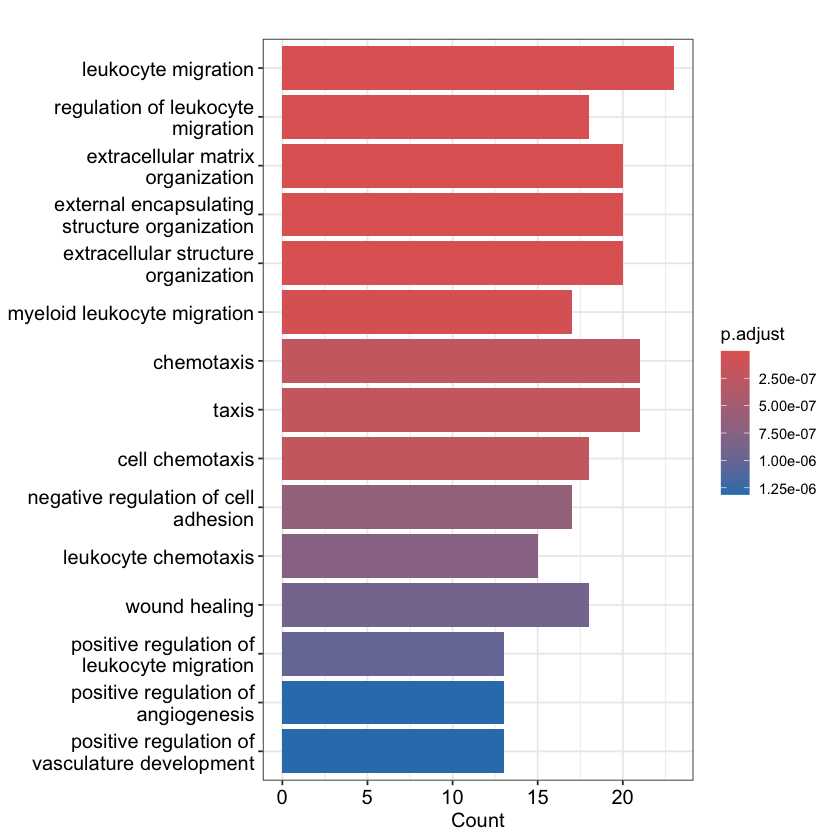

In [33]:
# /Users/gas361/Downloads/GSE133506_RAW/sva_mef_cleaned.csv
res = read.csv('/Users/gas361/Desktop/shared_MEF_ADP.txt', header=F)
# res
GO_results = enrichGO(gene = res$V1, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 15))



In [10]:
normalized_counts = counts(ddssva, normalized=TRUE)
write.csv(t(counts(ddssva, normalized=T)),'~/Desktop/SAMIRA/subnet/MEF_SVA_bulk.csv')

In [17]:
l1p = log1p(normalized_counts)

In [20]:
write.csv(t(l1p),'~/Desktop/SAMIRA/subnet_out/MEF_bulk.csv')

In [23]:
normalized_counts[c('Vegfa', 'Shox2', 'Fos', 'Jun'),]

,GSM3910499_NM1_WT_1,GSM3910500_NM1_WT_2,GSM3910501_NM1_WT_3,GSM3910502_NM1_KO_1,GSM3910503_NM1_KO_2,GSM3910504_NM1_KO_3
Vegfa,352.46000,371.31919,401.21317,520.37188,1246.02297,539.62872
Shox2,144.78155,130.21605,96.49431,293.91375,327.04517,303.65867
Fos,97.31219,73.24653,152.35943,81.91039,94.67097,92.13173
Jun,1422.89408,1442.54963,1560.41451,1687.07869,1669.65166,1916.90411


In [ ]:
# res = read.csv('/Users/gas361/Desktop/shared_MEF_ADP.txt', header=F)
# res


In [15]:
Resilient = c('Ntm', 'Gphn', 'Scd2', 'Camk2n1', 'Cmss1', 'Snrnp70', 'Lingo2', 'Smyd3', 'Plp1', 'Robo1', 'Sv2a', 'Psap', 'Ptprn', 'Lrrc7', 'Hspa8', 'Rtn1', 'Hsp90b1', 'Grik2', 'Ube2e2', 'Etnk1', 'Ctsb', 'Kcnip4', 'Clstn1', 'Rtn3', 'Aplp2', 'Grina', 'Ywhah', 'Hint1', 'Ahi1', 'Nrg3', 'Fam155a', 'Gdi1', 'Kalrn', 'Nisch', 'Necab2', 'Acp1', 'Srsf5', 'Tuba1b', 'Ube3a', 'Camk1d', 'Rbfox1', 'Grid1', 'Emc10', 'Calm2', 'Hs6st3', 'Slc22a17', 'Slc25a4', 'Ptprd', 'Ywhaz', 'Faf1', 'Adgrb3', 'Actb', 'Zcchc18', 'Mat2a', 'Ptprn2', 'Csmd1', 'Ndfip1', 'Ctnna2', 'Gnas', 'Slc25a3', 'Macrod2', 'Nap1l5', 'Gfra1', 'Ndrg4', 'Uqcrq', 'Atp6v0b', 'Bex2', 'Tmsb4x', 'Alcam', 'Ddx5', 'Kctd8', 'Cadm1', 'Gapdh', 'Shisa9', 'Cpe', 'Uqcrh', 'Atp5e', 'Sez6l2', 'Atp1a3', 'Rsrp1', 'Scn2b', 'Mt3', 'Mdh1', 'Ccdc85a', 'Pcsk1n', 'Ndufc2', 'Rasgrf1', 'Gprasp2', 'Agbl4', 'Ubl5', 'Zwint', 'Dlg2', 'Fau', 'Mbp', 'Map1b', 'Bsg', 'Atpif1', 'Dscam', 'Nrxn1', 'Fth1', 'Cntn5', 'Calm1', 'Slc24a3', 'Morf4l1', 'Arglu1', 'Gng8', 'Snhg11', 'Tmsb10', 'Tmem59l', 'Nnat', 'Gabrg3', 'Ubb', 'Maged1', 'Stxbp1', 'Uqcr11', 'Uqcr10', 'Fgf12', 'Calr', 'Cox6c', 'Eef1a1', 'Canx', 'Tecr', 'Tmem130', 'Snap25', 'Trpm3', 'Hsp90aa1', 'Serinc1', 'Atp5j', 'Aplp1', 'Chl1', 'Nsf', 'Atp1b1', 'Kcnc2', 'Pam', 'Grm7', 'H3f3b', 'Srrm2', 'Kcnma1', 'App', 'Olfm1', 'Srsf1', 'Astn1', 'Ndufa2', 'Magi2', 'Peg3', 'Thy1', 'Ndufa4', 'Atp6v0c', 'Chga', 'Fgf14', 'Nwd2', 'Dpp6', 'Ctsd', 'Ryr3', 'Atp5l', 'Spock2', 'Itm2b', 'Cox6b1', 'Cox7c', 'Pcp4', 'Nrxn2', 'Ly6h', 'Syt11', 'Itm2c', 'Frmd4a', 'Cd47', 'Rtn4', 'Aldoa', 'Syp', 'Zic1', 'Tenm1', 'Hnrnpa2b1', 'Tspan13', 'Tspyl4', 'Atp5k', 'Nlgn1', 'Gabbr1', 'Cox8a', 'Cox4i1', 'Calb2', 'Kcnh7', 'Chchd2', 'Hsp90ab1', 'Xkr4', 'Rora', 'Cox5b', 'Zfp385b', 'Ppia', 'Stmn3', 'Gm5741', 'Etv1', 'Atp5g3', 'Calm3', 'Nrxn3', 'Cacna2d1', 'Nptxr')
SI = c('Ntm', 'Zmym3', 'Camk2n1', 'Frmd5', 'Ralyl', 'Psap', 'Lrrc7', 'Nedd4l', 'Slc24a2', 'Srsf2', 'Cntnap5a', 'Atxn2l', 'Snhg9', 'Ahi1', 'Kalrn', 'Cdh18', 'Ppp2r2b', 'Ogt', 'Ctnnd2', 'Cst3', 'Acp1', 'Il1rapl1', 'Camk1d', 'Rbfox1', 'Calm2', 'Cdh8', 'Slc22a17', 'Zcchc18', 'Mat2a', 'Csmd1', 'Arl15', 'Erc2', 'Mgat4c', 'Abca2', 'Cpe', 'Mt3', 'Wsb1', 'Tjp1', 'Map1b', 'Slc35f1', 'Plcb4', 'Cntnap2', 'Gria2', 'Myl6', 'Rnf112', 'Arglu1', 'Galnt13', 'Snhg11', 'Tmsb10', 'Kcnq3', 'Miat', 'Nkain2', 'Prkar1a', 'Fgf12', 'Auts2', 'Gria4', 'Csmd3', 'Cox6c', 'Trpm3', 'Prickle1', 'Hsp90aa1', 'Klf12', 'Serinc1', 'Slc12a5', 'Aplp1', 'Syne1', 'Kcnc2', 'Tcf25', 'Hdac9', 'Slc16a11', 'Syt1', 'Pde4d', 'Lrba', 'Ly6h', 'Opcml', 'Syt11', 'Cacna1c', 'Celf5', 'Pja2', 'Aldoa', 'Ap2m1', 'Tmeff2', 'Cox8a', 'Chchd2', 'Negr1', 'Gnl3l', 'Cacna2d3', 'Chrm3', 'Btbd9', 'Cmss1', 'Akap8l', 'Tmem178b', 'Gria1', 'Grik2', 'Pde10a', 'Rgs7', 'Clstn1', 'Kcnip4', 'Fam193b', 'Lars2', 'Ywhah', 'Sntg1', 'Fam155a', 'Gdi1', 'Otud7a', 'Nisch', 'Cit', 'Lhfpl3', 'Necab2', 'Srsf5', 'Mbd5', 'Tuba1b', 'Ube3a', 'Rundc3a', 'Slc25a4', 'Ptprd', 'Tanc2', 'Adgrb3', 'Lrrc45', 'Ptprn2', 'Ndfip1', 'Wwox', 'Macrod2', 'Ncam2', 'Nap1l5', 'Rims1', 'Rnf220', 'Atp5e', 'Ttc14', 'Tuba1a', 'Akap6', 'Eif4a2', 'Pcsk1n', 'Ywhag', 'Gprasp2', 'Ubl5', 'Agbl4', 'Plxna4', 'Celf2', 'Gaa', 'Zwint', 'Eml6', 'Lrrc4c', 'Hnrnpu', 'Atpif1', 'Anks1b', 'Kirrel3', 'Cntn5', 'Spock3', 'Dip2c', 'Tenm3', 'Morf4l1', 'Cpeb3', 'Dab1', 'Plcb1', 'Pcbp2', 'Zfp804a', 'Cbarp', 'Upp2', 'Rabgap1l', 'Ubb', 'Maged1', 'Grm5', 'Ptprg', 'Cntnap5b', 'Dtx3', 'Uqcr11', 'Uqcr10', 'Hivep2', 'Eef1a2', 'Epha6', 'Ttr', 'Huwe1', 'Mirg', 'Gabrb2', 'Uchl1', 'Sgcz', 'Gabrb3', 'Rogdi', 'Rims2', 'Fgf14', 'Dpp6', 'Srrm1', 'Cox7c', 'Pcp4', 'Zfp445', 'Rtn4', 'Adarb2', 'Zic1', 'Nav3', 'Zranb2', 'Nlgn1', 'Cadm2', 'Rbms3', 'Hsp90ab1', 'Xkr4', 'Rora', 'Ppfia2', 'Atp5g3', 'Calm3', 'Nrxn3', 'Cacna2d1', 'Podxl2', 'Nptxr', 'Ccser1', 'Ptprs', 'Syt7', 'Lingo2', 'Dalrd3', 'Snrnp70', 'Ppp3ca', 'Nsg2', 'Mapk10', 'Inpp4b', 'Atrnl1', 'Pcdh15', 'Hnrnpdl', 'Akt3', 'Tia1', 'Grina', 'Stag1', 'Zbtb20', 'Kcnt1', 'Hint1', 'Exoc4', 'Samd12', 'Dgki', 'Slit3', 'Grid1', 'Hs6st3', 'Grid2', 'Faf1', 'Atxn1', 'Actb', 'Tnik', 'Ctnna2', 'Prkg1', 'Slc25a3', 'Ndrg4', 'Naaladl2', 'Atp6v0b', 'Hap1', 'Gapdh', 'Dcc', 'Cntn1', 'Uqcrh', 'Rsrp1', 'Etl4', 'Nktr', 'Lrfn5', 'Apoe', 'Luc7l3', 'Cpne7', 'Dscam', 'Nrxn1', 'Egfem1', 'Ewsr1', 'Prkce', 'Pnisr', 'Ankrd10', 'Tubb2a', 'Slc24a3', 'Tmem63b', 'Cacna1g', 'Ddx17', 'Gpm6a', 'H2afz', 'Gabrg3', 'B3galt1', 'BC005537', 'Pcdh7', 'Lrrtm4', 'Snap25', 'Tra2a', 'Asic2', 'Hecw2', 'Galntl6', 'App', 'Leng8', 'Cep112', 'Kcnd2', 'Olfm1', 'Dpp10', 'Srsf1', 'Magi2', 'Zeb1', 'Ndufa2', 'Peg3', 'Celf3', 'Prickle2', 'Atp6v0c', 'Ryr3', 'Atp5l', 'Cox6b1', 'Itm2c', 'Nf1', 'Camta1', 'Calb2', 'Chka', 'Kcnh7', 'Stmn1', 'Zfp385b', 'Ppia', 'Grin2b', 'Mdga2', 'Gpc6', 'Nrg1', 'Zfand3', 'Gphn', 'Lrp1b', 'Smyd3', 'Frmpd4', 'Pex5l', 'Aff3', 'Matk', 'Robo1', 'Cnksr2', 'Plp1', 'Sv2a', 'Ptprn', 'Dok6', 'Hspa8', 'Abcc5', 'Rtn1', 'Ube2e2', 'Stk25', 'Etnk1', 'Adgrl3', 'Dlgap1', 'Fus', 'Lsamp', 'Arhgap26', 'Kctd16', 'Nrg3', 'Khdrbs2', 'Cntn4', 'Nell2', 'Rgl2', 'Nol4', 'Klc1', 'Ywhaz', 'Nrg3os', 'Gpr158', 'Zfyve9', 'Kifc2', 'Gnas', 'Plcl1', 'Ncoa1', 'Bex2', 'Ddx5', 'Atp1a3', 'Shisa9', 'Jazf1', 'Sncb', 'Ccdc85a', 'Mdh1', 'Dmd', 'Gprasp1', 'Dlg2', 'Mbp', 'Ip6k1', 'Bin1', 'Grm1', 'Pcdh9', 'Dnm1', 'Calm1', 'Celf4', 'Pabpn1', 'Stxbp1', 'Gabbr2', 'Kcnb2', 'Syt4', 'Dync1h1', 'Atp5b', 'Tecr', 'Gucy1a2', 'Prnp', 'Ptpn4', 'Enox1', 'Grin2a', 'Atp1b1', 'Gpi1', 'H3f3b', 'Grm7', 'Srrm2', 'Gabrb1', 'Snx32', 'Nr3c2', 'Eno2', 'Ndufa4', 'Lncpint', 'Ube2b', 'Srsf11', 'Frmd4a', 'Kcnj3', 'Hnrnpa2b1', 'Atp5k', 'Gabbr1', 'Fbxl17', 'Rbm39', 'Mir124a-1hg', 'Sgcd', 'Rgs7bp', 'Grip1', 'Hnrnph1')
SPT = c('Ube2q2', 'Nol7', 'Epdr1', 'Hopx', 'Gmds', 'Mia2', 'Ggct', 'Plppr4', 'Sv2b', 'Dusp26', 'Tmx3', 'Gm14325', 'Nptx2', 'Rnaseh2c', 'Acp1', 'Bcl7b', 'Rbfox1', 'Rbx1', 'Bod1', 'Rsl24d1', 'Acbd5', 'Ehbp1', 'Arl15', 'Coa3', 'Timm10', 'Ormdl3', 'Twistnb', 'Pcdh11x', 'Bcap29', 'Ccdc107', 'Wdr26', 'Rab24', 'Gmps', 'Galnt16', 'Aifm1', 'Zranb1', 'Hspe1', 'Galnt13', 'Snhg11', 'Nus1', 'Evl', 'Nkain2', 'Mef2d', 'Tmem130', 'Cops4', 'Klf12', 'Snx3', 'Slc12a5', 'Bzw2', 'Morn2', 'Trim33', 'Zfp771', 'Pde4d', 'Glyr1', 'Ndufv2', 'Amd1', 'Rtf1', 'Zcrb1', 'Xrn1', 'Pdxk', 'Pcsk1', 'Prdx3', 'Ap1s1', 'Gabrg2', 'Cox8a', 'Krtcap2', 'Nono', 'Dnajc5', 'Hdlbp', 'Meaf6', 'Tceal5', 'Btbd1', 'Dlat', 'Hnrnpc', 'Ndufa8', 'Grin3a', 'Pgrmc2', 'Xpo7', 'Med10', 'Bclaf1', 'Dhx36', 'Cmpk1', 'Kcnip4', 'Mrpl36', 'Ten1', 'Paics', 'Med19', 'Psmb6', 'Swi5', 'Ppp1r9a', 'Rab2a', 'Fam155a', 'Kin', 'Otud7a', 'Nisch', 'Lrp11', 'Necab2', 'Snhg6', 'Cnih3', 'Tceal6', 'Glg1', 'Mrpl50', 'Unc50', 'Mink1', 'Wwox', 'Ei24', 'Macrod2', 'Ncam2', 'Cggbp1', 'Nsa2', 'Psip1', 'Ube2j2', 'Lamtor1', 'Atp1a1', 'Txn1', 'Nt5c', 'Pcsk1n', 'Sec61b', 'Tpt1', 'Mrpl23', 'Tceal1', 'Atpif1', 'Lsm6', 'Ylpm1', 'Hspa1b', 'Tmcc1', 'Esd', 'Tusc3', 'Cldnd1', 'Ubb', 'Dnajb9', 'Upf3a', 'Rabac1', 'Ubap2', 'Nudc', 'Irak1bp1', 'Ergic3', 'Polb', 'Ssbp1', 'Rab18', 'Tmem167', 'Med13l', 'Ntan1', 'Kdm2a', 'Tceal8', 'Psma7', 'Sgcz', 'Rims2', 'Fgf14', 'Dpp6', 'Hp1bp3', 'Arhgef9', 'Rgs4', 'Usp32', 'Mydgf', 'Nlgn1', 'Cwc15', 'Gspt1', 'Prmt2', 'Btbd10', 'Cyp51', 'Ptov1', 'Lrrfip2', 'St8sia3', 'Ddx42', 'Dnaja2', 'Fsd1', 'Celf6', 'Arpc1a', 'Sstr2', 'H2afj', 'Rer1', 'Lyrm2', 'Kmt2e', 'Rnf7', 'Mtx2', 'Stag1', 'Pnpla8', 'Nedd8', 'Htr5b', 'Samd12', 'Kif5c', 'Ptp4a2', 'Dgki', 'Prpf6', 'Gnaq', 'Nckap1', 'Sptb', 'Actb', 'Sncg', 'Ctnna2', 'Ift22', 'Ndrg4', 'Fxr1', 'Naaladl2', 'Chchd1', 'Hap1', 'Srgap3', 'Bola1', 'Fau', 'Rnf10', 'Pafah1b3', 'Pi4k2a', 'Kxd1', 'Srek1ip1', 'Myh10', 'Ncbp2', 'Ddx17', 'P4ha1', 'Gng8', 'Psmd5', 'Klhl1', 'Reep1', 'Scmh1', 'Bmpr2', 'Ube2i', 'Rab27b', 'Dner', 'Med21', 'Clvs2', 'Ctnnbip1', 'Bphl', 'Dst', 'Atp5f1', 'Lrrtm4', 'Phf21a', 'Ddt', 'Phactr1', 'Apoo', 'Hecw2', 'Galntl6', 'Hsd17b12', 'Btg1', 'Pmepa1', 'Emc2', 'Bag6', 'Aff2', 'Ufc1', 'Mrpl45', 'Tmem256', 'Yeats4', 'Kcnh7', 'Chka', 'Esco1', 'Mrpl20', 'Chd6', 'Wasl', 'Zfp638', 'Fam216a', 'Mtmr7', 'Pdia3', 'Psmc4', 'Ndufa9', 'Lrp1b', 'Fnta', 'Pex5l', 'Robo1', 'Riiad1', 'Snrnp25', 'Dok6', 'Mrpl57', 'Bola2', 'Timm22', 'Dennd1b', 'Cope', 'Dlgap1', 'Lsamp', 'Emc7', 'Orc6', 'Ccdc30', 'Oaz1', 'Lhx9', 'Foxp2', 'Cdk17', 'Ccdc124', 'Chsy3', 'Lars', 'Paxbp1', 'Zfyve9', 'Mapre3', 'Hpcal1', 'Ndfip2', 'Inafm1', 'Rbm26', 'Eif3i', 'Kpna4', 'Mbp', 'Cd200', 'Sh3bgrl', 'Khdrbs1', 'Hspa1a', 'Akr7a5', 'Bri3', 'Ormdl1', 'Aktip', 'Me1', 'Hint2', 'Cct5', 'Kcnn3', 'Mrps34', 'Tmem255a', 'Commd3', 'Stxbp1', 'Dync1h1', 'Glud1', 'Smim8', 'Psmc6', 'N6amt1', 'Arxes1', 'Bola3', 'Kmt5a', 'Lncpint', 'Atrx', 'Frmd4a', 'Caml', 'Baz2b', 'Mrpl40', 'Kcnk10', 'Cfap36', 'Fbxl17', 'Rala', 'Snrpb', 'Senp6', 'Sh3gl2', 'Erbb4', 'Ubxn1', 'Trappc2l', 'Mphosph8', 'Adcyap1', 'Kdsr', 'Abce1', 'Synj2bp', 'Txndc17', 'Mrps12', 'Ralyl', 'Lonp2', 'Rsbn1', 'Ddx3y', 'Cetn3', 'Anp32b', 'Vstm2b', 'Ap3s1', 'Atxn2l', 'Cyb5a', 'Syt5', 'Polr2i', 'Ssh2', 'Zfp292', 'Ahi1', 'Tppp3', 'Fchsd2', 'Cdh18', 'Impa1', 'Ogt', 'Ctnnd2', 'Rprd2', 'Dtymk', 'Slc35f4', 'Trpc4', 'Tmco1', 'Eno1', 'Atp2b3', 'Psme4', 'Acbd6', 'Cacybp', 'Erc2', 'Mgat4c', 'Lsm3', 'Mt3', 'Idi1', 'Zmynd8', 'Ptbp2', 'Cdk5r1', 'Tm2d1', 'Arid4a', 'Tmem246', 'Mrps28', 'Smim15', 'Fosb', 'Rwdd1', 'Fam104a', 'Scp2', 'Rnf112', 'Nol3', 'Eif4e', 'Vamp7', 'Ebpl', 'Erh', 'Csmd3', 'Sdcbp', 'Prkcb', 'Blcap', 'Znhit1', 'Trim35', 'Kcnh5', 'Vps4b', 'Srp72', 'Acadsb', 'Hsd17b10', 'Ubl3', 'Syt1', 'Tob1', 'Mllt3', 'Fos', 'Appl1', 'Camk2g', 'Celf5', 'Pou4f1', 'Pop7', 'Nudt3', 'Tmeff2', 'Psenen', 'Prkd1', 'Ddit3', 'Nap1l1', 'Mrpl34', 'Chrm3', 'Snx12', 'Setd5', 'Tmem199', 'Chchd10', 'Prr13', 'Sybu', 'Grik2', 'Mrps17', 'Clstn1', 'Spast', 'Zrsr2', 'Guk1', 'Adh5', 'Trappc6b', 'Sntg1', 'Chordc1', 'Cit', 'Thsd7a', 'Hs6st2', 'Glo1', 'Rac3', 'Hnrnpab', 'Ube3a', 'Ptprd', 'Sdhaf4', 'Stambp', 'Ywhab', 'Susd4', 'Lztfl1', 'Tmf1', 'Rnf220', 'Polr2j', 'Spock1', 'Gtf2a2', 'Ndel1', 'Tnr', 'Eml6', 'Fth1', 'Shoc2', 'Gdap1', 'Stxbp5', 'Spock3', 'Tll1', 'Zfp106', 'Supt6', 'Plcb1', 'Grm5', 'Lamtor3', 'Polr2f', 'Mrpl18', 'Ttr', 'Tmem14a', 'Magoh', 'Smdt1', 'Nr6a1', 'Baiap3', 'Mrpl21', 'Uqcrfs1', 'Cd63', 'Fuom', 'Pdcd10', 'Vdac3', 'Syngr1', 'Sdhaf1', 'Mtmr3', 'Rragd', 'Thsd7b', 'Dync1li1', 'Rtn4', 'Strap', 'Cadm2', 'Wdr83os', 'Xkr4', 'Tmem117', 'Nipsnap1', 'Cdv3', 'Bhlhb9', 'Kcnmb4', 'Ccser1', 'Uchl3', 'Cetn2', 'Snrnp70', 'Smarcd1', 'Crebzf', 'Arpc2', 'Stip1', 'Atp5g2', 'Arl6', 'Mrpl11', 'Mtif2', 'Mmgt2', 'Hdhd2', 'Plk2', 'Nagk', 'Ssr4', 'Usp10', 'Smarca5', 'Tia1', 'Ddhd2', 'Pmm1', 'Psmd6', 'Cytip', 'Fgfr2', 'Thap3', 'Gpbp1', 'Txndc15', 'Kcnj6', 'Grid2', 'Tnik', 'Exoc3', 'Prkg1', 'Kcnmb4os2', 'Anapc11', 'Dcc', 'Uqcrh', 'Ostc', 'Myt1l', 'Eif6', 'Braf', 'Nrxn1', 'Pbx3', 'Cbl', 'Rapgef6', 'Ndst4', 'Fbxl15', 'Laptm4a', 'Manbal', 'Gpm6a', 'Btg2', 'Tmem14c', 'Nnat', 'Fcf1', 'Scg3', 'Pdia6', 'Adcy8', 'Fyttd1', 'Snrnp27', 'Ktn1', 'Pin1', 'Polr2b', 'Dpp10', 'Immp1l', 'Srsf1', 'Ufm1', 'Aurkaip1', 'Ube2r2', 'Zeb1', 'Peg3', 'Cntln', 'Pafah1b2', 'Cfl2', 'Brk1', 'Tmem230', 'Top2b', 'Jund', 'Pum2', 'Srp14', 'Brd2', 'Gpx4', 'Eif2s1', 'Sfr1', 'Mettl16', 'Gphn', 'Ppp2cb', 'Nlk', 'Plp1', 'Ap2s1', 'Nfu1', 'Abcc5', 'Fam136a', 'Snrpd3', 'Atg12', 'Pigp', 'Mark1', 'Fra10ac1', 'Amer2', 'Gstm5', 'Khdrbs2', 'Pnmal1', 'Anapc13', 'Unc5d', 'Ndufs8', 'Acot13', 'Nrg3os', 'Tspyl5', 'Gcc2', 'Hmgb1', 'Plcl1', 'Ncoa1', 'Gabarapl2', 'Dmd', 'Gprasp1', 'Gadd45gip1', 'Nufip2', 'Sf3b2', 'Cul1', 'Chchd4', 'Tmem176b', 'Upf3b', 'Ttc9b', 'Araf', 'Cmip', 'Nsmce4a', 'Tvp23b', 'Dnajb1', 'Tomm40', 'Npas4', 'Aifm3', 'Exosc4', 'Rbm8a', 'Dennd5b', 'Pard3b', 'H3f3b', 'Grm7', 'Srrm2', 'Egr1', 'Syngr3', 'Ndufaf3', 'Eif3m', 'Slc2a13', 'Mien1', 'Dhx9', 'Mtmr6', 'Rbm3', 'Dgkb', 'Ccdc90b', 'B230118H07Rik', 'Lrch3', 'Nae1', 'Mob4', 'Slc8a1', 'Anp32e', 'Map2k4', 'Atp5c1', 'Psmd12', 'Zcchc17', 'Nyap2', 'Ntm', 'Camk2n1', 'Arl6ip5', 'Sgtb', 'Pdrg1', 'Ppid', 'Arl1', 'Cux1', 'Pdzd11', 'Drg1', 'Lyrm9', 'Mbd3', 'Map9', 'Snx14', 'Cdh10', 'Ik', 'Mrpl17', 'Bex4', 'Ankrd13c', 'Psma4', 'Smarcc2', 'Itgb3bp', 'Il1rapl1', 'Lsm7', 'Slc22a17', 'Sltm', 'Zcchc18', 'Purg', 'Diaph2', 'Ppdpf', 'Trappc2', 'Vps4a', 'Bex1', 'Snx6', 'Cntnap2', 'Sbds', 'Btbd3', 'Prepl', 'Gria2', 'Fam204a', 'Leprotl1', 'Rimbp2', 'Cdipt', 'Phb2', 'Timm13', 'Tceal3', 'Arglu1', 'Ciapin1', 'Dctn3', 'Pfdn4', 'Fgf12', 'Auts2', 'Fto', 'Gria4', 'Cox20', 'Mpp2', 'Trpm3', 'Hsp90aa1', 'Cdkn2d', 'Zmat2', 'Yipf3', 'Gnb4', 'Taf15', 'Ndufb9', 'Rrp1', 'Ranbp1', 'Sar1b', 'Syt11', 'Tmed9', 'Cox7a2l', 'Gbf1', 'Myl12b', 'Chchd2', 'Negr1', 'Plpp4', 'Sema3d', 'Cfap20', 'Tgs1', 'Pde6d', 'Gars', 'Rsl1d1', 'Gtf2f2', 'Auh', 'Wbp4', 'Mrpl51', 'Timm9', 'Fam184a', 'Pten', 'Vta1', 'Kdm5c', 'Galnt1', 'Grb10', 'Desi2', 'Mrpl43', 'Esf1', 'Yipf1', 'Usp46', 'Lhfpl3', 'Wrb', 'H2-Ke6', 'Htr2c', 'Use1', 'Adgrb3', 'Stim1', 'Ndfip1', 'Gm4876', 'Ccdc127', 'Kctd8', 'Srebf2', 'Spop', 'Rnf214', 'Snf8', 'Agbl4', 'Gaa', 'Eid2', 'Txnl4a', 'Cntn5', 'Fbxo2', 'Tmx2', 'Gm10076', 'Maged1', 'Ankrd46', 'Mtx1', 'Srp19', 'Eef1a1', 'Mrps26', 'Dcaf7', 'Rida', 'Vav3', 'Rb1cc1', 'Actr3', 'Rab21', 'Atp6v1f', 'Caly', 'Akap9', 'Dusp8', 'Nav3', 'C1qbp', 'Xbp1', 'Cnih1', 'Rbms3', 'Hsp90ab1', 'Hsph1', 'Tmem60', 'Kif1bp', 'Mrps16', 'Ech1', 'Fgfr1op2', 'Nrxn3', 'Zfand6', 'Ash1l', 'Brinp1', 'Traf3', 'Lingo2', 'Snrpd2', 'Trappc13', 'Fahd1', 'Gtf2b', 'Timm10b', 'Mcee', 'Pgls', 'Acyp1', 'Cdh2', 'Ncl', 'Odf2', 'Tfdp2', 'Psme1', 'Tpr', 'Slit3', 'Tmed3', 'Irf2bpl', 'Chmp2b', 'Dtnb', 'Bax', 'Dynlt3', 'Dusp1', 'Apba1', 'Tiprl', 'Amigo2', 'Taok3', 'Chd5', 'Ssu72', 'Dync2h1', 'Nktr', 'Apoe', 'Slc30a9', 'Spcs1', 'Metap2', 'Magohb', 'Dnajc7', 'Dscam', 'R3hdm2', 'Tgoln1', 'Pcm1', 'Luzp1', 'Ccdc59', 'Slc24a3', 'Mrpl10', 'Rgmb', 'Gcsh', 'Vstm2a', 'B3galt1', 'Pcdh7', 'Cisd2', 'Map6', 'Eif2s3x', 'Hsbp1', 'Cdc26', 'Ubtf', 'Dnajc19', 'Tmbim4', 'Cep112', 'Phyhipl', 'Chmp5', 'Rasa1', 'Pfn1', 'Fbxw2', 'G3bp1', 'Hist1h1e', 'Tcp1', 'Hnrnpm', 'Arl3', 'Cox4i1', 'Sh3glb1', 'Imp3', 'Sdf2', 'Smc3', 'Cox11', 'Etv1', 'Mdga2', 'Nrg1', 'Ndufab1', 'Smyd3', 'Fis1', 'Oprm1', 'Ptprn', 'Fam219a', 'Rtn1', 'Cyc1', 'Ube2e2', 'Med12l', 'Jkamp', 'Atox1', 'Susd6', 'Poglut1', 'Ccdc191', 'Spa17', 'Nrg3', 'Srsf10', 'Apopt1', 'Snapc1', 'Mapre1', 'Sacm1l', 'Tmem205', 'Akirin2', 'Arpc5l', 'Tmem126a', 'Map3k4', 'Ppa1', 'A930015D03Rik', 'Mrpl32', 'Ywhaz', 'Hspb11', 'Gnas', 'Tcf7l2', 'Uba5', 'Thoc7', 'Tm9sf4', 'Srpr', 'Fbxo9', 'Magi1', 'Dlg2', 'Dclk1', 'Pcdh9', 'Chchd7', 'Dnm1', 'Borcs7', 'Tma7', 'Pianp', 'Cited2', 'Sema6a', 'Kcnb2', 'Ago3', 'Sh3bgrl2', 'Actr6', 'Mrps14', 'Lcorl', 'Ralgps2', 'Pds5a', 'Mctp1', 'Ergic2', 'Gon4l', 'Atp1b1', 'Taf7', 'Coq7', 'Eml2', 'Lsm12', 'Cct3', 'Emc9', 'Ube2w', 'Cmc1', 'Pnrc1', 'Gabbr1', 'Kcnd3', 'Nfs1', 'Papola', 'Ube2s', 'Ube2ql1', 'Numb', 'Rrm2b', 'Ndufs3', 'Llph', 'Phf14', 'Psap', 'Lrrc7', 'Lrpap1', 'Mrpl54', 'Psd', 'Sorcs3', 'Fam193a', 'Stk3', 'Alyref', 'Rchy1', 'Calb1', 'Ppp2r2b', 'Arcn1', 'Tmem29', 'Tmx4', 'Vps13c', 'Cdh8', 'Csmd1', 'Ctxn2', 'Stub1', 'Slc39a10', 'Denr', 'Gpr151', 'Cpeb4', 'Pfdn5', 'Prrc2a', 'Coprs', 'Abcb7', 'Eif1ax', 'Polr3k', 'Smc1a', 'Nifk', 'Dnajc10', 'Slc35g2', 'Uhrf2', 'Ptcd2', 'Cacnb3', 'Arxes2', 'Miat', 'U2surp', 'Jakmip2', 'Smim19', 'Dnajb14', 'Prickle1', 'Eif4g3', 'Aig1', 'Ptprr', 'Atxn10', 'Rpp21', 'Pbx1', 'Trappc4', 'Pcbd1', 'Fez1', 'Higd2a', 'Sap18', 'Slirp', 'Gm36975', 'Dnajc24', 'Csnk2b', 'Nrn1', 'Mrpl41', 'Polr1d', 'Ift74', 'Enho', 'Ncoa2', 'P2ry14', 'Tmem191c', 'Maoa', 'Ric8b', 'Lsm1', 'Psmd1', 'Dda1', 'Rab28', 'Mdp1', 'Dguok', 'Micu1', 'Pea15a', 'Tmem178b', 'Mrps24', 'Gria1', 'Tesc', 'Dcun1d5', 'Rbms1', 'Tm2d2', 'Lars2', 'Nhlh2', 'Med30', 'Commd1', 'Immp2l', 'Gpx1', 'Osgep', 'Tanc2', 'Mrps33', 'Mrps6', 'Ptprn2', 'Nudcd3', 'Eif4h', 'Rims1', 'Nap1l5', 'Thrap3', 'Yipf4', 'Tuba1a', 'Zfp664', 'Lrrc4c', 'Zfp608', 'Fibp', 'BC031181', 'Msantd4',
'Plekhj1', 'Tenm3', 'Gm16599', 'Trappc1', 'Dnajc15', 'Hras', 'Cdc37', 'Upp2', 'Cntnap5b', 'Specc1', 'Mrpl9', 'Cuta', 'Aamp', 'Mbnl2', 'Clpp', 'Zbtb38', 'Setd3', 'Mrpl38', 'Fndc3a', 'Cebpz', 'Gm2694', 'Nat14', 'Parl', 'Mrps31', 'Klhl4', 'Add2', 'Rap2a', 'Zic1', 'Tspyl4', 'Dnajc12', 'Tmem70', 'Nub1', 'Rora', 'Cnih4', 'Ndufb10', 'Cyhr1', 'Nptxr', 'Srp9', 'Ptprs', 'Syt7', 'H3f3a', 'Rhoq', 'Naca', 'Timm17a', 'Mrfap1', 'Pcdh15', 'Akt3', 'Sptssa', 'Stx12', 'Exoc4', 'Rab5a', 'D3Ertd751e', 'Drap1', 'Nr4a2', 'Grid1', 'Faf1', 'Hagh', 'Cirbp', 'Slc25a14', 'Coq2', 'Fstl1', 'Krt10', 'Sez6l2', 'Cntn1', 'Ttyh1', 'Rsrp1', 'Anp32a', 'Uqcrc2', 'Lrfn5', 'Cbr1', 'Brd4', 'Frmd4b', 'Phb', 'Pbrm1', 'Ewsr1', 'Ankrd10', 'Phf3', 'Atad1', 'Hmox2', 'Sf3b5', 'Bnip3l', 'Gabrg3', 'Cacna2d2', 'Ccdc28b', 'Rragb', 'Lsm4', 'Sucla2', 'H2afv', 'Uri1', 'Ppig', 'Tmem158', 'Prmt1', 'Ppib', 'Kif3c', 'Mapkap1', 'Yif1b', 'Olfm1', 'Kcnd2', 'Med28', 'Magi2', 'Fbxo22', 'Ube2d1', 'Mcts1', 'Tmtc2', 'Zfp260', 'Ddrgk1', 'Atp6v0c', 'Mettl9', 'Uba52', 'Gm42372', 'Mllt11', 'Borcs8', 'Psme2', 'Smim14', 'Uvrag', 'Gm17018', 'Cnbp', 'Atp6v0a1', 'Calb2', 'Ndufaf2', 'Lin28b', 'Ppia', 'Mageh1', 'Phf20', 'Gm20642', 'Mrpl14', 'Frmpd4', 'Usp11', 'Resp18', 'Dbn1', 'Eid1', 'Zcchc7', 'Mrps5', 'Fbxw11', 'Etnk1', 'Epc1', 'Sumo1', 'Erp29', 'Nipbl', 'Kdm1a', 'Asph', 'Elp4', 'Tm9sf3', 'Cds2', 'Manf', 'Gopc', 'Ftl1', 'Gpr158', 'Pygo1', 'Fbxo10', 'Psmd11', 'Kifc2', 'Rhoa', 'Dnajc9', 'Ep300', 'Scg2', 'Wbp11', 'Jun', 'Atp1a3', 'Ccdc85a', 'Mrpl52', 'Arid5b', 'Mrpl33', 'Nudt2', 'Atg3', 'Eny2', 'Fstl5', 'Mrps15', 'Isca2', 'Anapc16', 'Cnot4', 'Sdf4', 'Calm1', 'Celf4', 'Ubxn2a', 'Hdgf', 'Capza2', 'Golgb1', 'Tm2d3', 'Pbx4', 'Enox1', 'Grin2a', 'Cystm1', 'Rbbp4', 'Tpd52l2', 'Fxyd7', 'Kif2a', 'Commd6', 'Wdr45b', 'Rsbn1l', 'Ctr9', 'Eif1', 'Edil3', 'Ufsp2', 'Churc1', 'Nucks1', 'Rgs7bp', 'Dpy30', 'Grip1', 'Slc2a3', 'Ldha', 'Rab9', 'Mrpl48', 'N4bp2l2')
TST = c('C1galt1c1', 'Ndufa9', 'Sh3glb2', 'Psmd1', 'Uchl3', 'St8sia3', 'Cmss1', 'Lingo2', 'Gars', 'Nol7', 'Mapk8ip1', 'Crebzf', 'Txndc17', 'Ube2q2', 'Mrpl14', 'Rsl1d1', 'Plp1', 'Enc1', 'Mrto4', 'Dbn1', 'Ccdc25', 'Nfu1', 'Lrrc7', 'Ppid', 'Hdhd2', 'Lrpap1', 'Timm9', 'Snrpd3', 'Dzank1', 'Psd', 'Timm17a', 'Dhx36', 'Mrfap1', 'Kcnip4', 'Dpm2', 'Atp1b2', 'Mrpl36', 'Atg12', 'Ssr4', 'Emc7', 'Vta1', 'Kmt2e', 'Mark1', 'Syt5', 'Amer2', 'Orc6', 'Zrsr2', 'Guk1', 'Med19', 'Smarca5', 'Galnt1', 'Lars2', 'Mrpl43', 'Esf1', 'Psmb6', 'Tmpo', 'Dnajc18', 'Ahi1', 'Fam155a', 'Mrpl17', 'Bex4', 'Srsf10', 'Chordc1', 'Psme1', 'Rab5a', 'Psma4', 'Nap1l2', 'Wrb', 'Crip2', 'Rprd2', 'Gpbp1', 'Dtymk', 'Rbfox1', 'Ptpn5', 'Arpc5l', 'Irf2bpl', 'Bcl7b', 'Commd1', 'Use1', 'Tceal6', 'Mterf3', 'Mrpl32', 'Actb', 'Bax', 'Txndc9', 'Tspyl5', 'Nlgn3', 'Smim13', 'Acbd6', 'Scg2', 'Gcc2', 'Wbp11', 'Eif4h', 'Atp6ap1', 'Ift22', 'Hmgb1', 'Plcl1', 'Slc39a10', 'Ppme1', 'Ncoa1', 'Denr', 'Thoc7', 'Kctd8', 'Snrpg', 'Sez6l2', 'Chgb', 'Chd5', 'Elmod1', 'Srgap3', 'Idi1', 'Nhp2', 'Pcsk1n', 'Psmd2', 'Arid5b', 'Srp9', 'Cnot7', 'Cdk5r1', 'Ift43', 'Kpna4', 'Pigk', 'Vps35', 'Mlec', 'Brd4', 'Supt20', 'Jarid2', 'Eny2', 'Gfpt1', 'Ccdc107', 'Mrps15', 'Atg3', 'Mrpl48', 'Snx6', 'Chchd4', 'Txnl4a', 'Rapgef6', 'Sbds', 'Grm1', 'Suco', 'Upf3b', 'Gmps', 'Plekhj1', 'Fam204a', 'Phf3', 'Tgoln1', 'Leprotl1', 'Arpp19', 'Sdf4', 'Pcm1', 'Aktip', 'Epha5', 'Hmox2', 'Pianp', 'Cdk5r2', 'Nol3', 'Dnajc15', 'Hras', 'Psmd5', 'Sf3b5', 'Cdc37', 'Arxes2', 'Tomm40', 'B3galnt1', 'Evl', 'Tmem59l', 'Pfdn4', 'Cldnd1', 'Polr2f', 'Mrpl9', 'Golgb1', 'Tm2d3', 'Sucla2', 'Irak1bp1', 'Srp19', 'Ttr', 'Cisd2', 'Cops4', 'H1fx', 'Map6', 'Ube3c', 'Babam1', 'Trpm3', 'Pdia6', 'Gnpda2', 'Bbs4', 'Aamp', 'Mrpl21', 'Ppig', 'Kcnc2', 'Hsd17b10', 'Pam', 'Got2', 'Fyttd1', 'Snrnp27', 'Grm7', 'Asic2', 'Prmt1', 'Kcnma1', 'Spryd3', 'Zbtb38', 'Pdap1', 'Ntan1', 'Immp1l', 'Phyhipl', 'Vdac3', 'Rnf6', 'Zfp771', 'Ranbp1', 'Hsd17b12', 'Dexi', 'Fxyd7', 'Caly', 'Erlec1', 'Akap9', 'Atrx', 'Cebpz', 'Rpp21', 'Tacc1', 'Nwd2', 'Rragd', 'Dab2ip', 'Ctr9', 'Hp1bp3', 'Cab39', 'Pura', 'Rtf1', 'Uba52', 'Gm42372', 'Arhgef9', 'Gdap1l1', 'Bnip3', 'Pld3', 'Pdxk', 'Ccl27a', 'Xbp1', 'Rala', 'Cnih1', 'Snrpb', 'Pnn', 'Dph3', 'Tmem256', 'Dnajc5', 'Ube2s', 'Myl12b', 'Churc1', 'Yeats4', 'Cwc15', 'Npdc1', 'Nucks1', 'Rora', 'Wdr83os', 'Dpy30', 'Sdf2', 'Ntng1', 'Erbb4', 'Fam98b', 'Garnl3', 'Arl8a', 'Polr1d', 'Ptov1', 'Nap1l1', 'Ldha', 'Ppm1k', 'Grin2b', 'Arpc5', 'Lrrfip2', 'Zfp512', 'Fam216a', 'Pdia3')
Susceptible = c('Ntm', 'Zmym3', 'Frmd5', 'Fut9', 'Grm8', 'Ralyl', 'Psap', 'Lrrc7', 'Nell1', 'Synpo2', 'Psd', 'Srsf2', 'Cntnap5a', 'Atxn2l', 'Snhg9', 'Ahi1', 'Kalrn', 'Cdh18', 'Ppp2r2b', 'Ogt', 'Ctnnd2', 'Cacnb2', 'Il1rapl1', 'Shisa6', 'Acp1', 'Tox', 'Ppm1e', 'Camk1d', 'Rbfox1', 'Calm2', 'Slc22a17', 'Zcchc18', 'Cbx3', 'Mat2a', 'Csmd1', 'Cdk8', 'Arl15', 'Erc2', 'Mgat4c', 'Abca2', 'Gabra4', 'Mt3', 'Wsb1', 'Tjp1', 'Map1b', 'Slc35f1', 'Plcb4', 'Cntnap2', 'Tmcc3', 'Efna5', 'Gria2', 'Rnf112', 'Arglu1', 'Galnt13', 'Cacnb3', 'Snhg11', 'Tmsb10', 'Atp6v1b2', 'Kcnq3', 'Miat', 'Thoc1', 'Ddx39b', 'Prkar1a', 'Fgf12', 'Auts2', 'Gria4', 'Cox6c', 'Csmd3', 'Trpm3', 'Prickle1', 'Hsp90aa1', 'Klf12', 'Serinc1', 'Slc12a5', 'Aplp1', 'Kcnc2', 'Trps1', 'Tcf25', 'Hdac9', 'Slc16a11', 'Unc13a', 'Syt1', 'Pde4d', 'Ppm1l', 'B3gat1', 'Ly6h', 'Opcml', 'Syt11', 'Cacna1c', 'Celf5', 'Pja2', 'Aldoa', 'Negr1', 'Gnl3l', 'Cacna2d3', 'Chrm3', 'Scube1', 'Mobp', 'Fam189a1', 'March1', 'Cmss1', 'Akap8l', 'Tmem178b', 'Atp8a2', 'Grik2', 'Snhg20', 'Pde10a', 'Rgs7', 'Kcnip4', 'Fam193b', 'Atp13a2', 'Impact', 'Lars2', 'Ywhah', 'Sntg1', 'Fam155a', 'Otud7a', 'Gdi1', 'Plekha5', 'Nisch', 'Lhfpl3', 'Thsd7a', 'Necab2', 'Srsf5', 'Mbd5', 'Tuba1b', 'Htr2c', 'Ube3a', 'Rundc3a', 'Slc25a4', 'Ptprd', 'Tanc2', 'Mapk8ip3', 'Adgrb3', 'Lrrc45', 'Ptprn2', 'Ndfip1', 'Ksr2', 'Wwox', 'Macrod2', 'Kcnab1', 'Ncam2', 'Sh3d19', 'Nap1l5', 'Rims1', 'Kctd8', 'Atp5e', 'Ttc14', 'Akap6', 'Eif4a2', 'Pcsk1n', 'Ywhag', 'Gprasp2', 'Rbm5', 'Plxna4', 'Agbl4', 'Celf2', 'Gaa', 'Zwint', 'Lrrc4c', 'Hnrnpu', 'Atpif1', 'Anks1b', 'Kirrel3', 'Fth1', 'Cntn5', 'Spock3', 'Cdh12', 'Tenm3', 'Nbea', 'Dab1', 'Cpeb3', 'Morf4l1', 'Son', 'Pcbp2', 'Rasgef1b', 'Zfp804a', 'Unc5c', 'Cbarp', 'Upp2', 'Ubb', 'Cntnap5b', 'Grm5', 'Maged1', 'Ptprg', 'Dtx3', 'Uqcr10', 'Hivep2', 'Eef1a2', 'Epha6', 'Ttr', 'Slc1a2', 'Huwe1', 'Mirg', 'Kcnma1', 'Gabrb2', 'Sgcz', 'Rogdi', 'Gabrb3', 'Ntrk2', 'Rims2', 'Hook1', 'Fgf14', 'Nwd2', 'Dpp6', 'Srrm1', 'Cox7c', 'Rtn4', 'Adarb2', 'Zic1', 'Apbb2', 'Nav3', 'Tspyl4', 'Zranb2', 'Nlgn1', 'Cadm2', 'Rbms3', 'Hsp90ab1', 'Xkr4', 'Rora', 'Gls', 'Ppfia2', 'Atp5g3', 'Calm3', 'Cadps', 'Nrxn3', 'Cacna2d1', 'Podxl2', 'Nptxr', 'Ccser1', 'Brinp1', 'Pde4b', 'Ptprs', 'Lingo2', 'Dalrd3', 'Snrnp70', 'Dgkz', 'Tmem132b', 'Nsg2', 'Agrn', 'Arhgap32', 'Mapk10', 'Inpp4b', 'Atrnl1', 'Pcdh15', 'Hnrnpdl', 'Akt3', 'Cdh2', 'Tia1', 'Kcnt1', 'Hint1', 'Msi2', 'Exoc4', 'Samd12', 'Dgki', 'Slit3', 'Grid1', 'Hs6st3', 'Grid2', 'Faf1', 'Atxn1', 'Actb', 'Tardbp', 'Ctnna2', 'Prkg1', 'Slc25a3', 'Apba1', 'Hivep3', 'Ndrg4', 'Vamp2', 'Atp6v0b', 'Naaladl2', 'Tshz2', 'Hap1', 'Gapdh', 'Cntn6', 'Dcc', 'Cntn1', 'Uqcrh', 'Ttyh1', 'Rsrp1', 'Etl4', 'Nktr', 'Lrfn5', 'Apoe', 'Luc7l3', 'Clvs1', 'Dscam', 'Nrxn1', 'Mmp16', 'Egfem1', 'Ewsr1', 'Pnisr', 'Grik1', 'Ankrd10', 'Rcn2', 'Tmem63b', 'Slc24a3', 'Cacna1g', 'Ddx17', 'H2afz', 'Gabrg3', 'Dpysl2', 'Cacna2d2', 'Tnrc6a', 'Dner', 'B3galt1', 'Zmat4', 'Kmt2a', 'Pcdh7', 'BC005537', 'Dst', 'Lrrtm4', 'Cstf2', 'Tra2a', 'Pde7b', 'Hecw2', 'Ndufa1', 'Leng8', 'Kcnd2', 'Dpp10', 'Srsf1', 'Zeb1', 'Magi2', 'Ildr2', 'Peg3', 'Celf3', 'Prickle2', 'Atp6v0c', 'Ryr3', 'Atp5l', 'Vti1a', 'Syp', 'Tspan13', 'Atp6v0a1', 'Kcnh7', 'Calb2', 'Ube2d3', 'Zfp385b', 'Ppia', 'Grin2b', 'Samd5', 'Etv1', 'Phactr3', 'Mdga2', 'Dynll2', 'Gpc6', 'Fgf13', 'Gphn', 'Scd2', 'Lrp1b', 'Ank2', 'Hnrnpk', 'Smyd3', 'Frmpd4', 'Aff3', 'Matk', 'Robo1', 'Plp1', 'Resp18', 'Gm20754', 'Ptprn', 'Hspa8', 'Abcc5', 'Rtn1', 'Cntn3', 'Far1', 'Ube2e2', 'Jakmip1', 'Stk25', 'Etnk1', 'Adgrl3', 'Dlgap1', 'Fus', 'Lsamp', 'Rap1gap', 'Arhgap26', 'Kctd16', 'Lhx9', 'Nrg3', 'Khdrbs2', 'Cntn4', 'Prpf4b', 'Sod1', 'Unc5d', 'Luc7l2', 'Scn1a', 'Nell2', 'Rgl2', 'Cacna1e', 'Zcchc12', 'Klc1', 'Ywhaz', 'Gpr158', 'Kifc2', 'Scg2', 'Sf3b1', 'Gfra1', 'Plcl1', 'Bex2', 'Ddx5', 'Atp1a3', 'Shisa9', 'Jazf1', 'Sncb', 'Mdh1', 'Ccdc85a', 'Dmd', 'Gprasp1', 'Sgip1', 'Dlg2', 'Sorbs2', 'Mbp', 'Ip6k1', 'Plekhg1', 'Bin1', 'Grm1', 'Pcdh9', 'Dnm1', 'Csnk1a1', 'Kcnq5', 'Calm1', 'Tenm4', 'Shc3', 'Fam172a', 'Tial1', 'Srrm4', 'Bcas1', 'Pabpn1', 'Krit1', 'Srgap2', 'Kcnb2', 'Stxbp1', 'Dync1h1', 'Trank1', 'Clstn2', 'Tecr', 'Gucy1a2', 'Ptpn4', 'Grin2a', 'Atp1b1', 'Pam', 'H3f3b', 'Gpi1', 'Grm7', 'Srrm2', 'Pclo', 'Gabrb1', 'Snx32', 'Slc2a13', 'Nr3c2', 'Eno2', 'Ndufa4', 'Lncpint', 'Ube2b', 'Srsf11', 'Dlc1', 'Frmd4a', 'Edil3', 'Kcnj3', 'Hnrnpa2b1', 'Atp5k', 'Gabbr1', 'Lrch1', 'Fbxl17', 'Rbm39', 'Rgs7bp', 'Grip1', 'Nav2', 'Erbb4', 'Ntng1', 'Nmnat2', 'Hnrnph1', 'Mycbp2')

pheno = list('Resilient'=Resilient, 'SI'=SI,'SPT'=SPT, 'TST'=TST, 'Susceptible'=Susceptible)


In [16]:
for(p in names(pheno)){
    print(p)
    pheno[[p]] = pheno[[p]][!grepl("^mt-", pheno[[p]])]
    pheno[[p]] = pheno[[p]][!grepl("^Rpp", pheno[[p]])]
    
    GO_results = enrichGO(gene = pheno[[p]], OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
    # # head(as.data.frame(GO_results))
    # # plot(barplot(GO_results, showCategory = 15))
    pl = barplot(GO_results, showCategory = 25)
    ggsave(paste0(p,"_GO_barplot.pdf"), plot = pl, width = 10, height = 8)
    }



[1] "Resilient"
[1] "SI"
[1] "SPT"
[1] "TST"
[1] "Susceptible"


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050807,GO:0050807,regulation of synapse organization,38/391,309/28891,4.468785e-25,1.686073e-21,1.194812e-21,Kalrn/Ogt/Il1rapl1/Cdh8/Negr1/Clstn1/Ube3a/Ptprd/Tanc2/Adgrb3/Tuba1a/Zfp804a/Nlgn1/Ppfia2/Ptprs/Lingo2/Grid1/Grid2/Ctnna2/Lrfn5/Apoe/Nrxn1/Gpm6a/Lrrtm4/Asic2/App/Magi2/Nf1/Grin2b/Mdga2/Nrg1/Frmpd4/Robo1/Hspa8/Adgrl3/Ywhaz/Gpr158/Prnp,38
GO:0050803,GO:0050803,regulation of synapse structure or activity,38/391,317/28891,1.140744e-24,2.152014e-21,1.524995e-21,Kalrn/Ogt/Il1rapl1/Cdh8/Negr1/Clstn1/Ube3a/Ptprd/Tanc2/Adgrb3/Tuba1a/Zfp804a/Nlgn1/Ppfia2/Ptprs/Lingo2/Grid1/Grid2/Ctnna2/Lrfn5/Apoe/Nrxn1/Gpm6a/Lrrtm4/Asic2/App/Magi2/Nf1/Grin2b/Mdga2/Nrg1/Frmpd4/Robo1/Hspa8/Adgrl3/Ywhaz/Gpr158/Prnp,38
GO:0042391,GO:0042391,regulation of membrane potential,45/391,491/28891,3.994957e-24,5.024324e-21,3.560418e-21,Nedd4l/Cntnap2/Kcnq3/Fgf12/Kcnc2/Cacna1c/Gria1/Grik2/Rgs7/Ywhah/Rims1/Akap6/Ubb/Gabrb2/Gabrb3/Rims2/Fgf14/Dpp6/Nlgn1/Calm3/Cacna2d1/Ppp3ca/Dgki/Grid2/Atxn1/Nrxn1/Prkce/Cacna1g/Gabrg3/Asic2/App/Kcnd2/Kcnh7/Grin2b/Pex5l/Atp1a3/Dmd/Bin1/Calm1/Celf4/Grin2a/Atp1b1/Gabrb1/Nr3c2/Rgs7bp,45
GO:0050890,GO:0050890,cognition,38/391,371/28891,3.319623e-22,3.131234e-19,2.218906e-19,Camk2n1/Slc24a2/Kalrn/Ctnnd2/Csmd1/Cntnap2/Slc12a5/Pde4d/Syt11/Cacna1c/Pja2/Btbd9/Gria1/Ube3a/Adgrb3/Tuba1a/Cpeb3/Plcb1/Grm5/Gabrb3/Nrxn3/Dgki/Atxn1/Ndrg4/Apoe/Nrxn1/Snap25/App/Nf1/Grin2b/Nrg1/Gpr158/Gnas/Atp1a3/Syt4/Prnp/Grin2a/Grm7,38
GO:0007611,GO:0007611,learning or memory,36/391,331/28891,5.694273e-22,4.296898e-19,3.044937e-19,Camk2n1/Slc24a2/Kalrn/Ctnnd2/Csmd1/Cntnap2/Slc12a5/Pde4d/Syt11/Cacna1c/Pja2/Btbd9/Gria1/Ube3a/Adgrb3/Tuba1a/Cpeb3/Plcb1/Grm5/Gabrb3/Nrxn3/Dgki/Atxn1/Ndrg4/Apoe/Nrxn1/Snap25/App/Nf1/Grin2b/Nrg1/Atp1a3/Syt4/Prnp/Grin2a/Grm7,36
GO:0007626,GO:0007626,locomotory behavior,33/391,273/28891,1.133436e-21,7.127423e-19,5.050749e-19,Psap/Kalrn/Abca2/Cntnap2/Fgf12/Cacna1c/Negr1/Btbd9/Ube3a/Tuba1a/Gaa/Dab1/Grm5/Uchl1/Fgf14/Zic1/Mapk10/Pcdh15/Atxn1/Cntn1/Apoe/Dscam/Prkce/Snap25/App/Kcnd2/Nrg1/Adgrl3/Lsamp/Atp1a3/Dmd/Grm1/Grin2a,33


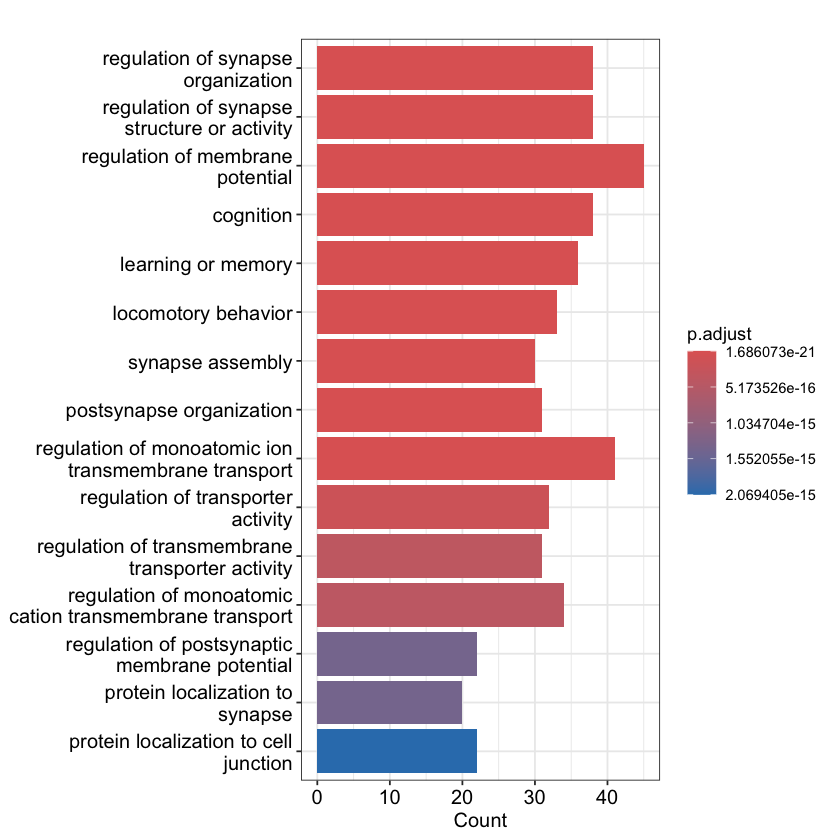

In [11]:
for(p in names(pheno)){
    pheno[[p]] = pheno[[p]][!grepl("^mt-", pheno[[p]])]
    pheno[[p]] = pheno[[p]][!grepl("^Rpp", pheno[[p]])]
    
    GO_results = enrichGO(gene = pheno[[p]], OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
    # # head(as.data.frame(GO_results))
    # # plot(barplot(GO_results, showCategory = 15))
    p = barplot(GO_results, showCategory = 25)
    ggsave(paste0(p,"_GO_barplot.pdf"), plot = p, width = 10, height = 8)
    }



,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0032543,GO:0032543,mitochondrial translation,45/1219,130/28891,3.767789e-29,1.969423e-25,1.482526e-25,Coa3/Mrpl36/Mrpl50/Mrpl23/Chchd1/Mrpl45/Mrpl20/Mrpl57/Mrps34/Mrpl40/Mrps12/Mrps28/Mrpl34/Mrps17/Mrpl18/Mrpl21/Mrpl11/Mtif2/Aurkaip1/Gadd45gip1/Mrpl17/Gars/Mrpl51/Mrpl43/Mrps26/C1qbp/Mrps16/Mrpl10/Mrpl32/Mrps14/Mrpl54/Mrpl41/Mrps24/Lars2/Mrps33/Mrps6/Mrpl9/Mrpl38/Mrps31/Mrpl14/Mrps5/Mrpl52/Mrpl33/Mrps15/Mrpl48,45
GO:0140053,GO:0140053,mitochondrial gene expression,47/1219,166/28891,5.104612e-26,1.334090e-22,1.004265e-22,Coa3/Mrpl36/Mrpl50/Mrpl23/Chchd1/Mrpl45/Mrpl20/Mrpl57/Mrps34/Mrpl40/Mrps12/Mrps28/Hsd17b10/Mrpl34/Chchd10/Mrps17/Mrpl18/Mrpl21/Mrpl11/Mtif2/Aurkaip1/Gadd45gip1/Mrpl17/Gars/Mrpl51/Mrpl43/Mrps26/C1qbp/Mrps16/Mrpl10/Mrpl32/Mrps14/Mrpl54/Mrpl41/Mrps24/Lars2/Mrps33/Mrps6/Mrpl9/Mrpl38/Mrps31/Mrpl14/Mrps5/Mrpl52/Mrpl33/Mrps15/Mrpl48,47
GO:0006397,GO:0006397,mRNA processing,71/1219,496/28891,1.790458e-19,3.119575e-16,2.348327e-16,Rbfox1/Zcrb1/Nono/Hnrnpc/Dhx36/Kin/Psip1/Lsm6/Cwc15/Celf6/Prpf6/Fxr1/Srek1ip1/Ncbp2/Ddx17/Aff2/Snrnp25/Paxbp1/Rbm26/Khdrbs1/Snrpb/Rprd2/Lsm3/Ptbp2/Nol3/Celf5/Zrsr2/Supt6/Plcb1/Magoh/Strap/Snrnp70/Tia1/Snrnp27/Srsf1/Snrpd3/Fra10ac1/Khdrbs2/Sf3b2/Rbm8a/Srrm2/Dhx9/Rbm3/Ik/Lsm7/Sltm/Zmat2/Wbp4/Txnl4a/C1qbp/Snrpd2/Ncl/Ssu72/Magohb/Hnrnpm/Srsf10/Thoc7/Papola/Alyref/Ptcd2/Sap18/Slirp/Lsm1/Thrap3/Mbnl2/Cirbp/Rsrp1/Sf3b5/Lsm4/Wbp11/Celf4,71
GO:0008380,GO:0008380,RNA splicing,66/1219,449/28891,8.538950e-19,9.505277e-16,7.155302e-16,Rbfox1/Zcrb1/Nono/Hnrnpc/Psip1/Lsm6/Cwc15/Celf6/Prpf6/Fxr1/Srek1ip1/Ncbp2/Ddx17/Aff2/Zfp638/Snrnp25/Paxbp1/Khdrbs1/Snrpb/Lsm3/Ptbp2/Nol3/Celf5/Zrsr2/Supt6/Magoh/Strap/Snrnp70/Tia1/Snrnp27/Srsf1/Snrpd3/Fra10ac1/Khdrbs2/Sf3b2/Rbm8a/Srrm2/Dhx9/Rbm3/Ik/Lsm7/Zmat2/Taf15/Wbp4/Txnl4a/C1qbp/Snrpd2/Ncl/Magohb/Hnrnpm/Srsf10/Thoc7/Alyref/Sap18/Slirp/Lsm1/Thrap3/Mbnl2/Cirbp/Rsrp1/Sf3b5/Lsm4/Prmt1/Wbp11/Eny2/Celf4,66
GO:0000375,GO:0000375,"RNA splicing, via transesterification reactions",53/1219,304/28891,1.272947e-18,9.505277e-16,7.155302e-16,Rbfox1/Zcrb1/Hnrnpc/Psip1/Lsm6/Cwc15/Celf6/Prpf6/Fxr1/Ncbp2/Ddx17/Snrnp25/Paxbp1/Khdrbs1/Snrpb/Lsm3/Ptbp2/Nol3/Celf5/Zrsr2/Magoh/Strap/Snrnp70/Tia1/Srsf1/Snrpd3/Fra10ac1/Khdrbs2/Sf3b2/Rbm8a/Srrm2/Dhx9/Rbm3/Ik/Lsm7/Zmat2/Wbp4/Txnl4a/C1qbp/Snrpd2/Ncl/Magohb/Hnrnpm/Srsf10/Sap18/Slirp/Thrap3/Mbnl2/Cirbp/Rsrp1/Sf3b5/Lsm4/Celf4,53
GO:0000377,GO:0000377,"RNA splicing, via transesterification reactions with bulged adenosine as nucleophile",53/1219,304/28891,1.272947e-18,9.505277e-16,7.155302e-16,Rbfox1/Zcrb1/Hnrnpc/Psip1/Lsm6/Cwc15/Celf6/Prpf6/Fxr1/Ncbp2/Ddx17/Snrnp25/Paxbp1/Khdrbs1/Snrpb/Lsm3/Ptbp2/Nol3/Celf5/Zrsr2/Magoh/Strap/Snrnp70/Tia1/Srsf1/Snrpd3/Fra10ac1/Khdrbs2/Sf3b2/Rbm8a/Srrm2/Dhx9/Rbm3/Ik/Lsm7/Zmat2/Wbp4/Txnl4a/C1qbp/Snrpd2/Ncl/Magohb/Hnrnpm/Srsf10/Sap18/Slirp/Thrap3/Mbnl2/Cirbp/Rsrp1/Sf3b5/Lsm4/Celf4,53


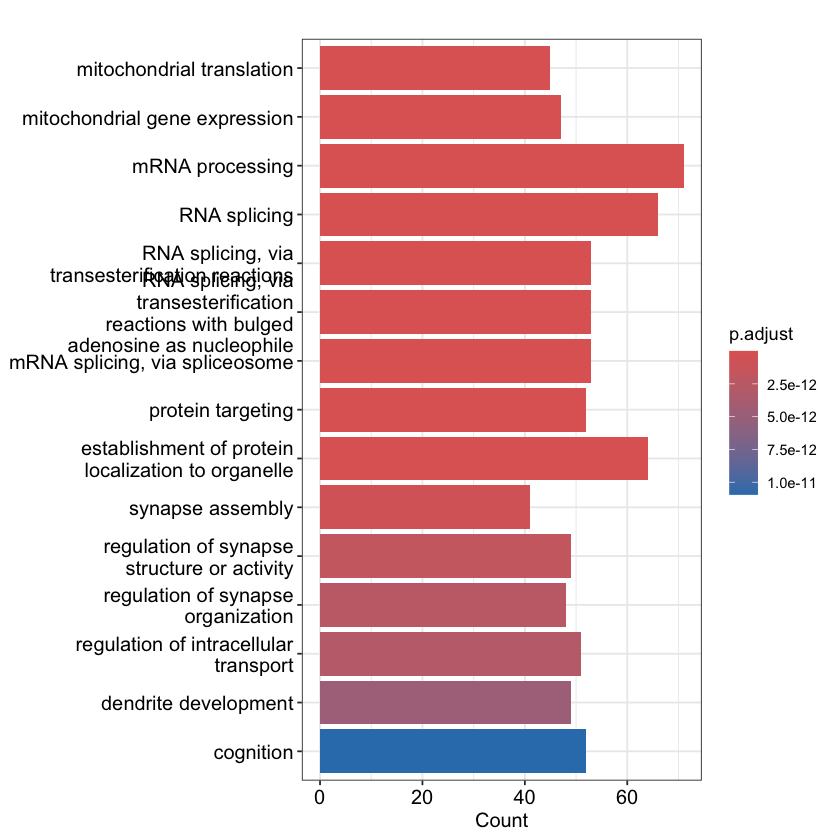

In [10]:
GO_results = enrichGO(gene = SPT, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 15))
p <- barplot(GO_results, showCategory = 15)
ggsave("SPT_GO_barplot.pdf", plot = p, width = 10, height = 8)



,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0140053,GO:0140053,mitochondrial gene expression,13/255,166/28891,3.164234e-09,9.366133e-06,8.100440e-06,Gars/Mrpl14/Mrpl36/Lars2/Mrpl43/Mrpl17/Mterf3/Mrpl32/Mrps15/Mrpl48/Mrpl9/Mrpl21/Hsd17b10,13
GO:0072655,GO:0072655,establishment of protein localization to mitochondrion,10/255,99/28891,1.882005e-08,2.321025e-05,2.007373e-05,Timm9/Timm17a/Ptpn5/Bax/Chchd4/Nol3/Dnajc15/Tomm40/Immp1l/Rala,10
GO:0032543,GO:0032543,mitochondrial translation,11/255,130/28891,2.352390e-08,2.321025e-05,2.007373e-05,Gars/Mrpl14/Mrpl36/Lars2/Mrpl43/Mrpl17/Mrpl32/Mrps15/Mrpl48/Mrpl9/Mrpl21,11
GO:0043653,GO:0043653,mitochondrial fragmentation involved in apoptotic process,5/255,12/28891,3.878269e-08,2.583487e-05,2.234367e-05,Bax/Vps35/Atg3/Bnip3/Erbb4,5
GO:0070585,GO:0070585,protein localization to mitochondrion,10/255,108/28891,4.363999e-08,2.583487e-05,2.234367e-05,Timm9/Timm17a/Ptpn5/Bax/Chchd4/Nol3/Dnajc15/Tomm40/Immp1l/Rala,10
GO:0006839,GO:0006839,mitochondrial transport,11/255,158/28891,1.751500e-07,8.640735e-05,7.473068e-05,Timm9/Timm17a/Ptpn5/Bax/Vps35/Chchd4/Nol3/Dnajc15/Tomm40/Immp1l/Bnip3,11


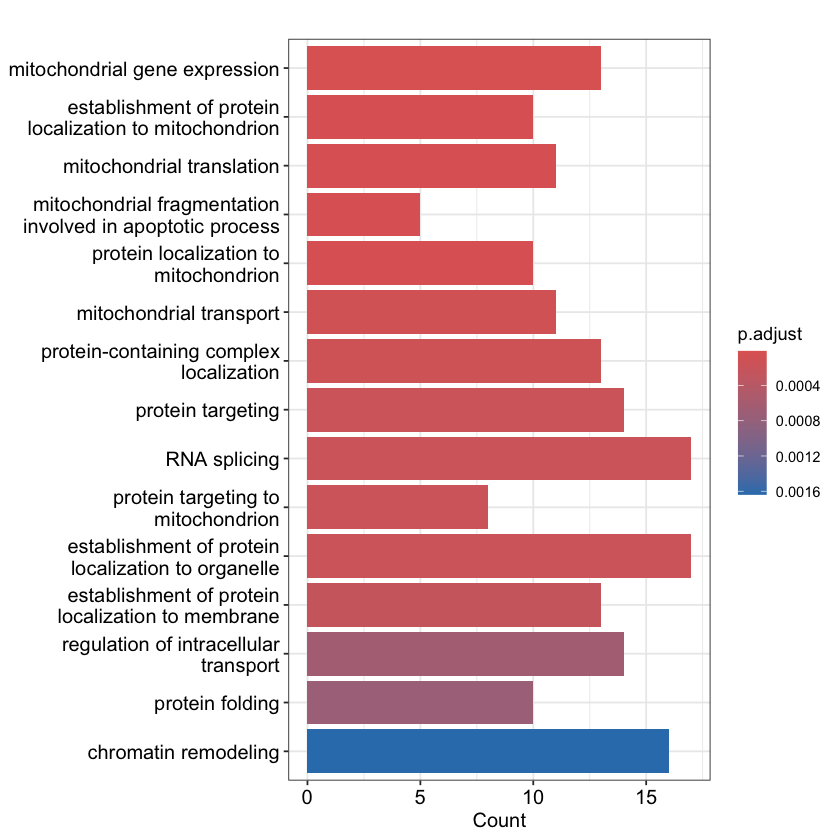

In [9]:
GO_results = enrichGO(gene = TST, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 15))
p <- barplot(GO_results, showCategory = 15)
ggsave("tst_GO_barplot.pdf", plot = p, width = 10, height = 8)




,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0042391,GO:0042391,regulation of membrane potential,49/453,491/28891,5.648780e-25,1.837181e-21,1.345127e-21,Cacnb2/Gabra4/Cntnap2/Cacnb3/Kcnq3/Fgf12/Kcnc2/Cacna1c/Grik2/Rgs7/Ywhah/Rims1/Akap6/Ubb/Kcnma1/Gabrb2/Gabrb3/Ntrk2/Rims2/Fgf14/Dpp6/Nlgn1/Calm3/Cacna2d1/Agrn/Dgki/Grid2/Atxn1/Nrxn1/Grik1/Cacna1g/Gabrg3/Kcnd2/Kcnh7/Grin2b/Fgf13/Ank2/Sod1/Scn1a/Atp1a3/Dmd/Bin1/Calm1/Grin2a/Atp1b1/Pclo/Gabrb1/Nr3c2/Rgs7bp,49
GO:0007416,GO:0007416,synapse assembly,35/453,222/28891,9.651593e-25,1.837181e-21,1.345127e-21,Psd/Ogt/Il1rapl1/Cntnap2/Efna5/Negr1/Ptprd/Adgrb3/Kirrel3/Cntn5/Gabrb2/Gabrb3/Ntrk2/Nlgn1/Nrxn3/Nptxr/Ptprs/Lingo2/Agrn/Cdh2/Grid2/Lrfn5/Nrxn1/Lrrtm4/Magi2/Mdga2/Fgf13/Robo1/Adgrl3/Nrg3/Srgap2/Clstn2/Pclo/Erbb4/Mycbp2,35
GO:0034765,GO:0034765,regulation of monoatomic ion transmembrane transport,48/453,490/28891,3.966351e-24,5.033300e-21,3.685227e-21,Cacnb2/Calm2/Cacnb3/Kcnq3/Fgf12/Kcnc2/Pde4d/Cacna1c/Cacna2d3/Rgs7/Kcnip4/Ywhah/Slc25a4/Kcnab1/Akap6/Cbarp/Grm5/Kcnma1/Fgf14/Dpp6/Calm3/Cacna2d1/Pde4b/Agrn/Vamp2/Hap1/Cacna2d2/Hecw2/Kcnd2/Dpp10/Tspan13/Kcnh7/Fgf13/Ank2/Plp1/Scn1a/Cacna1e/Dmd/Bin1/Kcnq5/Calm1/Kcnb2/Grin2a/Atp1b1/Nr3c2/Ndufa4/Kcnj3/Grip1,48
GO:0099173,GO:0099173,postsynapse organization,34/453,252/28891,8.220296e-22,6.336040e-19,4.639054e-19,Psd/Kalrn/Ctnnd2/Il1rapl1/Shisa6/Cntnap2/Ube3a/Ptprd/Tanc2/Zfp804a/Nlgn1/Ppfia2/Nrxn3/Nptxr/Ptprs/Dgkz/Agrn/Cdh2/Grid1/Grid2/Actb/Apoe/Nrxn1/Lrrtm4/Magi2/Grin2b/Gphn/Hnrnpk/Frmpd4/Hspa8/Adgrl3/Dlg2/Sorbs2/Grin2a,34
GO:0050807,GO:0050807,regulation of synapse organization,37/453,309/28891,8.321566e-22,6.336040e-19,4.639054e-19,Psd/Kalrn/Ogt/Il1rapl1/Efna5/Negr1/Ube3a/Ptprd/Tanc2/Adgrb3/Zfp804a/Ntrk2/Nlgn1/Ppfia2/Ptprs/Lingo2/Agrn/Cdh2/Grid1/Grid2/Ctnna2/Lrfn5/Apoe/Nrxn1/Lrrtm4/Magi2/Grin2b/Mdga2/Hnrnpk/Frmpd4/Robo1/Hspa8/Adgrl3/Ywhaz/Gpr158/Clstn2/Mycbp2,37
GO:0050803,GO:0050803,regulation of synapse structure or activity,37/453,317/28891,2.028339e-21,1.286981e-18,9.422882e-19,Psd/Kalrn/Ogt/Il1rapl1/Efna5/Negr1/Ube3a/Ptprd/Tanc2/Adgrb3/Zfp804a/Ntrk2/Nlgn1/Ppfia2/Ptprs/Lingo2/Agrn/Cdh2/Grid1/Grid2/Ctnna2/Lrfn5/Apoe/Nrxn1/Lrrtm4/Magi2/Grin2b/Mdga2/Hnrnpk/Frmpd4/Robo1/Hspa8/Adgrl3/Ywhaz/Gpr158/Clstn2/Mycbp2,37


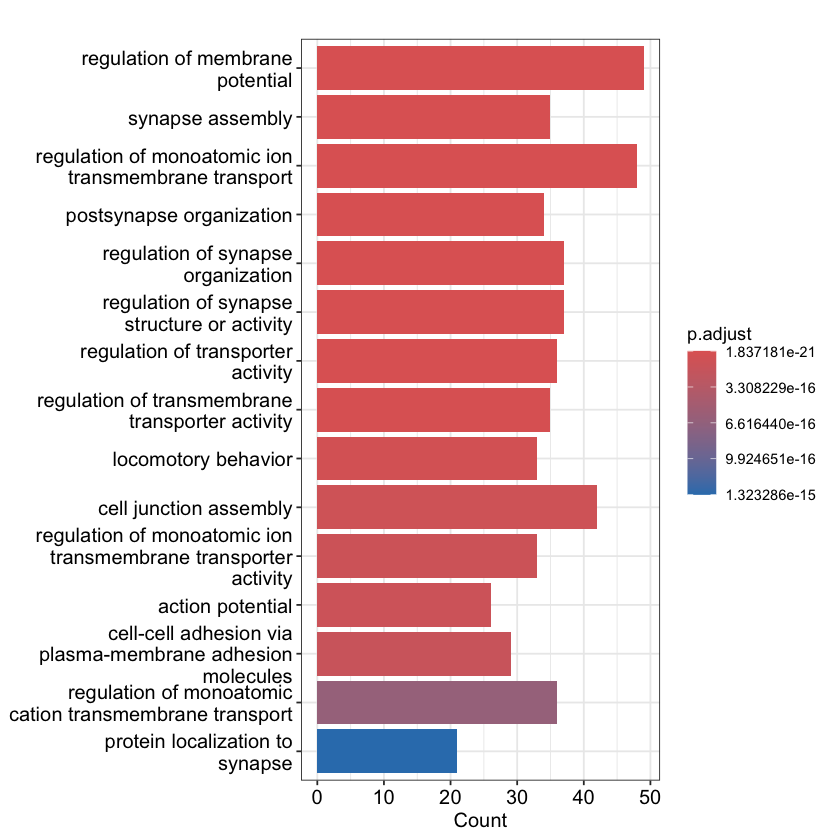

In [8]:
GO_results = enrichGO(gene = Susceptible, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 15))
p <- barplot(GO_results, showCategory = 15)
ggsave("Susceptible_GO_barplot.pdf", plot = p, width = 10, height = 8)



In [17]:
?enrichGO

enrichGO {clusterProfiler},R Documentation
gene,a vector of entrez gene id.
OrgDb,OrgDb
keyType,keytype of input gene
ont,"One of ""BP"", ""MF"", and ""CC"" subontologies, or ""ALL"" for all three."
pvalueCutoff,adjusted pvalue cutoff on enrichment tests to report
pAdjustMethod,"one of ""holm"", ""hochberg"", ""hommel"", ""bonferroni"", ""BH"", ""BY"", ""fdr"", ""none"""
universe,"background genes. If missing, the all genes listed in the database (eg TERM2GENE table) will be used as background."
qvalueCutoff,"qvalue cutoff on enrichment tests to report as significant. Tests must pass i) pvalueCutoff on unadjusted pvalues, ii) pvalueCutoff on adjusted pvalues and iii) qvalueCutoff on qvalues to be reported."
minGSSize,minimal size of genes annotated by Ontology term for testing.
maxGSSize,maximal size of genes annotated for testing
